In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt
import time
import copy
import os

In [2]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size=1
learning_rate = 0.001
layers = 100

transforms = transforms.Compose([
    transforms.Resize(48),
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
train_dataset = datasets.ImageFolder(root='emotion_FixedVer_TrainTest/train/', transform=transforms)
test_dataset = datasets.ImageFolder(root='emotion_FixedVer_TrainTest/test/', transform=transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [3]:
class BasicBlock(nn.Module):
    def __init__(self,in_planes,out_planes,dropRate = 0.0):
        #input dimsnsion을 정하고, output dimension을 정하고(growh_rate임), dropRate를 정함.
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace = True) # inplace 하면 input으로 들어온 것 자체를 수정하겠다는 뜻. 메모리 usage가 좀 좋아짐. 하지만 input을 없앰.
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride = 1, padding = 1, bias = False)
        self.droprate = dropRate
        
    def forward(self,x):
        out = self.conv1(self.relu(self.bn1(x)))
        if self.droprate>0:
            out = F.dropout (out,p=self.droprate,training = self.training)
        return torch.cat([x,out],1)
        
class BottleneckBlock(nn.Module):
    def __init__(self,in_planes,out_planes,dropRate=0.0):
        #out_planes => growh_rate를 입력으로 받게 된다.
        super(BottleneckBlock,self).__init__()
        inter_planes = out_planes * 4 # bottleneck layer의 conv 1x1 filter chennel 수는 4*growh_rate이다.
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace = True)
        self.conv1 = nn.Conv2d(in_planes,inter_planes,kernel_size=1,stride=1,padding=0,bias=False)
        self.bn2 = nn.BatchNorm2d(inter_planes)
        self.conv2 = nn.Conv2d(inter_planes,out_planes,kernel_size=3,stride=1,padding=1,bias=False)
        self.droprate = dropRate
        
    def forward(self,x):
        out = self.conv1(self.relu(self.bn1(x)))
        if self.droprate>0:
            out = F.dropout(out,p=self.droprate,inplace=False,training = self.training)
        out = self.conv2(self.relu(self.bn2(out)))
        if self.droprate>0:
            out = F.dropout(out,p=self.droprate,inplace=False,training = self.training)
        return torch.cat([x,out],1) # 입력으로 받은 x와 새로 만든 output을 합쳐서 내보낸다

In [4]:
class DenseBlock(nn.Module):
    def __init__(self,nb_layers,in_planes,growh_rate,block,dropRate=0.0):
        super(DenseBlock,self).__init__()
        self.layer = self._make_layer(block, in_planes, growh_rate, nb_layers, dropRate)
    
    def _make_layer(self,block,in_planes,growh_rate,nb_layers,dropRate):
        layers=[]
        for i in range(nb_layers):
            layers.append(block(in_planes + i*growh_rate ,growh_rate,dropRate))
            
        return nn.Sequential(*layers)
    
    def forward(self,x):
        return self.layer(x)

In [5]:
class TransitionBlock(nn.Module):
    def __init__(self,in_planes,out_planes,dropRate=0.0):
        super(TransitionBlock,self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes,out_planes,kernel_size=1,stride=1,padding=0,bias=False)
        self.droprate = dropRate
        
    def forward(self,x):
        out = self.conv1(self.relu(self.bn1(x)))
        if self.droprate>0:
            out = F.dropout(out,p=self.droprate,inplace=False,training=self.training)
        return F.avg_pool2d(out,2)

In [6]:
class DenseNet(nn.Module):
    def __init__(self,depth,num_classes,growh_rate=12,reduction=0.5,bottleneck=True,dropRate=0.0):
        super(DenseNet,self).__init__()
        num_of_blocks = 3
        in_planes = 16 # 2 * growh_rate
        n = (depth - num_of_blocks - 1)/num_of_blocks # 총 depth에서 첫 conv , 2개의 transit , 마지막 linear 빼고 / num_of_blocks
        if reduction != 1 :
            in_planes = 2 * growh_rate
        if bottleneck == True:
            in_planes = 2 * growh_rate #논문에서 Bottleneck + Compression 할 경우 first layer은 2*growh_rate라고 했다.
            n = n/2 # conv 1x1 레이어가 추가되니까 !
            block = BottleneckBlock 
        else :
            block = BasicBlock
        
        n = int(n) #n = DenseBlock에서 block layer 개수를 의미한다.
        self.conv1 = nn.Conv2d(3,in_planes,kernel_size=3,stride=1,padding=1,bias=False) # input:RGB -> output:growhR*2
        
        
        #1st block
        # nb_layers,in_planes,growh_rate,block,dropRate
        self.block1 = DenseBlock(n,in_planes,growh_rate,block,dropRate)
        in_planes = int(in_planes+n*growh_rate) # 입력 + 레이어 만큼의 growh_rate
        
        # in_planes,out_planes,dropRate
        self.trans1 = TransitionBlock(in_planes, int(math.floor(in_planes*reduction)),dropRate=dropRate)
        in_planes = int(math.floor(in_planes*reduction))
        
        
        #2nd block
        # nb_layers,in_planes,growh_rate,block,dropRate
        self.block2 = DenseBlock(n,in_planes,growh_rate,block,dropRate)
        in_planes = int(in_planes+n*growh_rate) # 입력 + 레이어 만큼의 growh_rate
        
        # in_planes,out_planes,dropRate
        self.trans2 = TransitionBlock(in_planes, int(math.floor(in_planes*reduction)),dropRate=dropRate)
        in_planes = int(math.floor(in_planes*reduction))
        
        
        #3rd block
        # nb_layers,in_planes,growh_rate,block,dropRate
        self.block3 = DenseBlock(n,in_planes,growh_rate,block,dropRate)
        in_planes = int(in_planes+n*growh_rate) # 입력 + 레이어 만큼의 growh_rate
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace = True)
        
        self.fc = nn.Linear(in_planes,num_classes) # 마지막에 ave_pool 후에 1x1 size의 결과만 남음.
        
        self.in_planes = in_planes
        
        # module 초기화
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # Conv layer들은 필터에서 나오는 분산 root(2/n)로 normalize 함
                # mean = 0 , 분산 = sqrt(2/n) // 이게 무슨 초기화 방법이었는지 기억이 안난다.
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d): # shifting param이랑 scaling param 초기화(?)
                m.weight.data.fill_(1) # 
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):# linear layer 초기화.
                m.bias.data.zero_()
        
    def forward(self,x):
        #x : 32*32
        out = self.conv1(x) # 32*32
        out = self.block1(out) # 32*32
        out = self.trans1(out) # 16*16
        out = self.block2(out) # 16*16
        out = self.trans2(out) # 8*8
        out = self.block3(out) # 8*8
        out = self.relu(self.bn1(out)) #8*8
        out = F.avg_pool2d(out,8) #1*1
        out = out.view(-1, self.in_planes) #channel수만 남기 때문에 Linear -> in_planes
        return self.fc(out)

In [7]:
#model = torch.load('DenseNetModelSave.pt')
model = DenseNet(layers,10,growh_rate=12,dropRate = 0.0)


# get the number of model parameters
# 재미있는 코드라서 들고와봄.
print('Number of model parameters: {}'.format(
    sum([p.data.nelement() for p in model.parameters()])))

model = model.to(device)

criterion = nn.CrossEntropyLoss().to(device)#해보자 한번
#optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)
optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate,
                            momentum=0.9,nesterov=True,weight_decay=1e-4)

Number of model parameters: 769162


In [8]:
def train(train_loader,model,criterion,optimizer,epoch):
    model.train()
    for i, (input,target) in enumerate(train_loader):
        target = target.to(device)
        input = input.to(device)
        
        output = model(input)
        loss = criterion(output,target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if(i%20 == 0):
            print("loss in epoch %d , step %d : %f" % (epoch, i,loss.data))

In [9]:
def test(test_loader,model,criterion,epoch):
    model.eval()
    
    correct = 0
    
    
    for i, (input,target) in enumerate(test_loader):
        target = target.to(device)
        input = input.to(device)
        
        output = model(input)
        loss = criterion(output,target)
        
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().float().sum()
    
    print("Accuracy in epoch %d : %f" % (epoch,100.0*correct/len(test_loader.dataset)))

In [10]:
def adjust_lr(optimizer, epoch, learning_rate):
    if epoch==15 :
        learning_rate*=0.1
        for param_group in optimizer.param_groups:
            param_group['lr'] = learning_rate

In [11]:
for epoch in range(0,20):
    adjust_lr(optimizer,epoch,learning_rate)
    train(train_loader,model,criterion,optimizer,epoch)
    test(test_loader,model,criterion,epoch)
    # ... after training, save your model 
    torch.save(model, 'DenseNetModelSave.pt')

loss in epoch 0 , step 0 : 2.460646
loss in epoch 0 , step 20 : 1.628861
loss in epoch 0 , step 40 : 2.802648
loss in epoch 0 , step 60 : 1.319558
loss in epoch 0 , step 80 : 2.103217
loss in epoch 0 , step 100 : 2.323822
loss in epoch 0 , step 120 : 1.525142
loss in epoch 0 , step 140 : 2.023942
loss in epoch 0 , step 160 : 1.477506
loss in epoch 0 , step 180 : 2.635135
loss in epoch 0 , step 200 : 1.928623
loss in epoch 0 , step 220 : 1.804159
loss in epoch 0 , step 240 : 1.633147
loss in epoch 0 , step 260 : 1.131948
loss in epoch 0 , step 280 : 1.990479
loss in epoch 0 , step 300 : 1.221726
loss in epoch 0 , step 320 : 2.426719
loss in epoch 0 , step 340 : 1.254447
loss in epoch 0 , step 360 : 1.688887
loss in epoch 0 , step 380 : 1.305776
loss in epoch 0 , step 400 : 1.274635
loss in epoch 0 , step 420 : 2.549459
loss in epoch 0 , step 440 : 2.082726
loss in epoch 0 , step 460 : 2.156009
loss in epoch 0 , step 480 : 1.586052
loss in epoch 0 , step 500 : 2.281213
loss in epoch 0 , 

loss in epoch 0 , step 4240 : 1.408625
loss in epoch 0 , step 4260 : 1.915622
loss in epoch 0 , step 4280 : 0.987378
loss in epoch 0 , step 4300 : 1.194398
loss in epoch 0 , step 4320 : 1.493425
loss in epoch 0 , step 4340 : 1.807475
loss in epoch 0 , step 4360 : 2.748307
loss in epoch 0 , step 4380 : 1.895328
loss in epoch 0 , step 4400 : 1.334299
loss in epoch 0 , step 4420 : 2.333988
loss in epoch 0 , step 4440 : 2.169950
loss in epoch 0 , step 4460 : 2.231863
loss in epoch 0 , step 4480 : 3.220804
loss in epoch 0 , step 4500 : 1.568775
loss in epoch 0 , step 4520 : 1.902367
loss in epoch 0 , step 4540 : 1.101636
loss in epoch 0 , step 4560 : 1.688417
loss in epoch 0 , step 4580 : 1.008453
loss in epoch 0 , step 4600 : 1.158932
loss in epoch 0 , step 4620 : 2.148693
loss in epoch 0 , step 4640 : 2.053548
loss in epoch 0 , step 4660 : 1.328503
loss in epoch 0 , step 4680 : 1.538968
loss in epoch 0 , step 4700 : 2.256471
loss in epoch 0 , step 4720 : 1.468189
loss in epoch 0 , step 47

loss in epoch 0 , step 8460 : 2.858404
loss in epoch 0 , step 8480 : 1.844612
loss in epoch 0 , step 8500 : 1.907733
loss in epoch 0 , step 8520 : 1.291613
loss in epoch 0 , step 8540 : 1.102414
loss in epoch 0 , step 8560 : 0.861679
loss in epoch 0 , step 8580 : 1.874113
loss in epoch 0 , step 8600 : 1.879731
loss in epoch 0 , step 8620 : 1.332223
loss in epoch 0 , step 8640 : 2.172588
loss in epoch 0 , step 8660 : 2.047453
loss in epoch 0 , step 8680 : 1.974102
loss in epoch 0 , step 8700 : 1.121273
loss in epoch 0 , step 8720 : 2.199615
loss in epoch 0 , step 8740 : 2.167726
loss in epoch 0 , step 8760 : 1.545709
loss in epoch 0 , step 8780 : 1.867905
loss in epoch 0 , step 8800 : 2.303628
loss in epoch 0 , step 8820 : 1.890254
loss in epoch 0 , step 8840 : 2.150928
loss in epoch 0 , step 8860 : 1.753917
loss in epoch 0 , step 8880 : 0.998254
loss in epoch 0 , step 8900 : 2.135320
loss in epoch 0 , step 8920 : 1.450131
loss in epoch 0 , step 8940 : 2.002392
loss in epoch 0 , step 89

loss in epoch 0 , step 12600 : 1.769675
loss in epoch 0 , step 12620 : 2.480384
loss in epoch 0 , step 12640 : 1.588082
loss in epoch 0 , step 12660 : 1.795255
loss in epoch 0 , step 12680 : 1.778934
loss in epoch 0 , step 12700 : 1.259963
loss in epoch 0 , step 12720 : 1.531678
loss in epoch 0 , step 12740 : 1.645630
loss in epoch 0 , step 12760 : 1.461940
loss in epoch 0 , step 12780 : 1.679114
loss in epoch 0 , step 12800 : 1.508867
loss in epoch 0 , step 12820 : 1.810031
loss in epoch 0 , step 12840 : 2.472244
loss in epoch 0 , step 12860 : 1.457730
loss in epoch 0 , step 12880 : 1.450042
loss in epoch 0 , step 12900 : 2.007078
loss in epoch 0 , step 12920 : 2.044086
loss in epoch 0 , step 12940 : 1.798537
loss in epoch 0 , step 12960 : 2.025398
loss in epoch 0 , step 12980 : 1.115930
loss in epoch 0 , step 13000 : 2.137632
loss in epoch 0 , step 13020 : 2.036578
loss in epoch 0 , step 13040 : 1.683956
loss in epoch 0 , step 13060 : 1.570574
loss in epoch 0 , step 13080 : 1.763716


loss in epoch 0 , step 16700 : 1.398897
loss in epoch 0 , step 16720 : 2.230672
loss in epoch 0 , step 16740 : 1.576988
loss in epoch 0 , step 16760 : 2.065333
loss in epoch 0 , step 16780 : 1.750304
loss in epoch 0 , step 16800 : 1.867079
loss in epoch 0 , step 16820 : 2.065050
loss in epoch 0 , step 16840 : 1.366978
loss in epoch 0 , step 16860 : 2.052722
loss in epoch 0 , step 16880 : 2.554487
loss in epoch 0 , step 16900 : 2.191084
loss in epoch 0 , step 16920 : 2.720558
loss in epoch 0 , step 16940 : 1.964914
loss in epoch 0 , step 16960 : 1.568431
loss in epoch 0 , step 16980 : 2.326305
loss in epoch 0 , step 17000 : 2.328448
loss in epoch 0 , step 17020 : 1.159228
loss in epoch 0 , step 17040 : 1.714211
loss in epoch 0 , step 17060 : 1.600200
loss in epoch 0 , step 17080 : 1.234033
loss in epoch 0 , step 17100 : 2.409417
loss in epoch 0 , step 17120 : 1.893511
loss in epoch 0 , step 17140 : 1.641556
loss in epoch 0 , step 17160 : 1.937340
loss in epoch 0 , step 17180 : 2.036841


loss in epoch 1 , step 880 : 1.728444
loss in epoch 1 , step 900 : 2.617552
loss in epoch 1 , step 920 : 1.580474
loss in epoch 1 , step 940 : 1.500597
loss in epoch 1 , step 960 : 1.304971
loss in epoch 1 , step 980 : 1.935431
loss in epoch 1 , step 1000 : 1.458786
loss in epoch 1 , step 1020 : 1.342290
loss in epoch 1 , step 1040 : 2.053436
loss in epoch 1 , step 1060 : 1.747373
loss in epoch 1 , step 1080 : 1.982870
loss in epoch 1 , step 1100 : 1.538667
loss in epoch 1 , step 1120 : 1.376190
loss in epoch 1 , step 1140 : 1.408177
loss in epoch 1 , step 1160 : 2.126888
loss in epoch 1 , step 1180 : 1.962526
loss in epoch 1 , step 1200 : 1.689281
loss in epoch 1 , step 1220 : 1.652871
loss in epoch 1 , step 1240 : 1.724078
loss in epoch 1 , step 1260 : 1.728831
loss in epoch 1 , step 1280 : 2.230725
loss in epoch 1 , step 1300 : 1.203486
loss in epoch 1 , step 1320 : 1.523552
loss in epoch 1 , step 1340 : 1.929313
loss in epoch 1 , step 1360 : 1.766730
loss in epoch 1 , step 1380 : 1

loss in epoch 1 , step 5100 : 1.354728
loss in epoch 1 , step 5120 : 1.448033
loss in epoch 1 , step 5140 : 1.378367
loss in epoch 1 , step 5160 : 1.727359
loss in epoch 1 , step 5180 : 2.314321
loss in epoch 1 , step 5200 : 1.287998
loss in epoch 1 , step 5220 : 1.785314
loss in epoch 1 , step 5240 : 1.274787
loss in epoch 1 , step 5260 : 1.880508
loss in epoch 1 , step 5280 : 2.038670
loss in epoch 1 , step 5300 : 2.102087
loss in epoch 1 , step 5320 : 1.892275
loss in epoch 1 , step 5340 : 1.626556
loss in epoch 1 , step 5360 : 1.584393
loss in epoch 1 , step 5380 : 1.822944
loss in epoch 1 , step 5400 : 1.554172
loss in epoch 1 , step 5420 : 1.545368
loss in epoch 1 , step 5440 : 2.146767
loss in epoch 1 , step 5460 : 2.019047
loss in epoch 1 , step 5480 : 1.474388
loss in epoch 1 , step 5500 : 1.976860
loss in epoch 1 , step 5520 : 2.068845
loss in epoch 1 , step 5540 : 1.681103
loss in epoch 1 , step 5560 : 1.531104
loss in epoch 1 , step 5580 : 1.766967
loss in epoch 1 , step 56

loss in epoch 1 , step 9320 : 1.959208
loss in epoch 1 , step 9340 : 1.659152
loss in epoch 1 , step 9360 : 1.474171
loss in epoch 1 , step 9380 : 1.561506
loss in epoch 1 , step 9400 : 1.980486
loss in epoch 1 , step 9420 : 1.326124
loss in epoch 1 , step 9440 : 1.435284
loss in epoch 1 , step 9460 : 2.160824
loss in epoch 1 , step 9480 : 2.102712
loss in epoch 1 , step 9500 : 1.317461
loss in epoch 1 , step 9520 : 0.822152
loss in epoch 1 , step 9540 : 1.695562
loss in epoch 1 , step 9560 : 1.761982
loss in epoch 1 , step 9580 : 2.488520
loss in epoch 1 , step 9600 : 1.450386
loss in epoch 1 , step 9620 : 2.357539
loss in epoch 1 , step 9640 : 1.554471
loss in epoch 1 , step 9660 : 1.513445
loss in epoch 1 , step 9680 : 1.493034
loss in epoch 1 , step 9700 : 1.036685
loss in epoch 1 , step 9720 : 2.058303
loss in epoch 1 , step 9740 : 1.804766
loss in epoch 1 , step 9760 : 1.190121
loss in epoch 1 , step 9780 : 1.419661
loss in epoch 1 , step 9800 : 2.032134
loss in epoch 1 , step 98

loss in epoch 1 , step 13440 : 2.146586
loss in epoch 1 , step 13460 : 1.786137
loss in epoch 1 , step 13480 : 1.741094
loss in epoch 1 , step 13500 : 1.936149
loss in epoch 1 , step 13520 : 1.709060
loss in epoch 1 , step 13540 : 1.491251
loss in epoch 1 , step 13560 : 1.350082
loss in epoch 1 , step 13580 : 1.622701
loss in epoch 1 , step 13600 : 1.476973
loss in epoch 1 , step 13620 : 2.682565
loss in epoch 1 , step 13640 : 1.375178
loss in epoch 1 , step 13660 : 1.618650
loss in epoch 1 , step 13680 : 1.500264
loss in epoch 1 , step 13700 : 2.076526
loss in epoch 1 , step 13720 : 1.754593
loss in epoch 1 , step 13740 : 1.692723
loss in epoch 1 , step 13760 : 2.219126
loss in epoch 1 , step 13780 : 2.140472
loss in epoch 1 , step 13800 : 2.043367
loss in epoch 1 , step 13820 : 2.047492
loss in epoch 1 , step 13840 : 1.838584
loss in epoch 1 , step 13860 : 1.467324
loss in epoch 1 , step 13880 : 1.525401
loss in epoch 1 , step 13900 : 1.734791
loss in epoch 1 , step 13920 : 1.275293


loss in epoch 1 , step 17540 : 1.980335
loss in epoch 1 , step 17560 : 1.864521
loss in epoch 1 , step 17580 : 2.197903
loss in epoch 1 , step 17600 : 1.520347
loss in epoch 1 , step 17620 : 1.751697
loss in epoch 1 , step 17640 : 1.899966
loss in epoch 1 , step 17660 : 1.469639
loss in epoch 1 , step 17680 : 1.600479
loss in epoch 1 , step 17700 : 2.283043
loss in epoch 1 , step 17720 : 1.859537
loss in epoch 1 , step 17740 : 2.102993
loss in epoch 1 , step 17760 : 1.660471
loss in epoch 1 , step 17780 : 1.856757
loss in epoch 1 , step 17800 : 1.500443
loss in epoch 1 , step 17820 : 2.081386
loss in epoch 1 , step 17840 : 1.378478
loss in epoch 1 , step 17860 : 1.278848
loss in epoch 1 , step 17880 : 1.938999
loss in epoch 1 , step 17900 : 1.654318
loss in epoch 1 , step 17920 : 1.772993
loss in epoch 1 , step 17940 : 1.568449
loss in epoch 1 , step 17960 : 2.155983
loss in epoch 1 , step 17980 : 2.019862
loss in epoch 1 , step 18000 : 2.937202
loss in epoch 1 , step 18020 : 1.321933


loss in epoch 2 , step 1740 : 1.661587
loss in epoch 2 , step 1760 : 1.694700
loss in epoch 2 , step 1780 : 2.346367
loss in epoch 2 , step 1800 : 1.379995
loss in epoch 2 , step 1820 : 1.635188
loss in epoch 2 , step 1840 : 2.321251
loss in epoch 2 , step 1860 : 2.053783
loss in epoch 2 , step 1880 : 1.645998
loss in epoch 2 , step 1900 : 1.196880
loss in epoch 2 , step 1920 : 1.144414
loss in epoch 2 , step 1940 : 0.924893
loss in epoch 2 , step 1960 : 3.081310
loss in epoch 2 , step 1980 : 2.189068
loss in epoch 2 , step 2000 : 2.323022
loss in epoch 2 , step 2020 : 1.261962
loss in epoch 2 , step 2040 : 1.800060
loss in epoch 2 , step 2060 : 1.705957
loss in epoch 2 , step 2080 : 1.258129
loss in epoch 2 , step 2100 : 2.083948
loss in epoch 2 , step 2120 : 1.066571
loss in epoch 2 , step 2140 : 2.643469
loss in epoch 2 , step 2160 : 1.927195
loss in epoch 2 , step 2180 : 2.324392
loss in epoch 2 , step 2200 : 2.337602
loss in epoch 2 , step 2220 : 1.763735
loss in epoch 2 , step 22

loss in epoch 2 , step 5960 : 1.853030
loss in epoch 2 , step 5980 : 2.717786
loss in epoch 2 , step 6000 : 0.722765
loss in epoch 2 , step 6020 : 1.794132
loss in epoch 2 , step 6040 : 1.876184
loss in epoch 2 , step 6060 : 2.184354
loss in epoch 2 , step 6080 : 2.074217
loss in epoch 2 , step 6100 : 1.366775
loss in epoch 2 , step 6120 : 1.159590
loss in epoch 2 , step 6140 : 1.381760
loss in epoch 2 , step 6160 : 2.150731
loss in epoch 2 , step 6180 : 1.714040
loss in epoch 2 , step 6200 : 1.395276
loss in epoch 2 , step 6220 : 1.971514
loss in epoch 2 , step 6240 : 1.342018
loss in epoch 2 , step 6260 : 1.304313
loss in epoch 2 , step 6280 : 1.917990
loss in epoch 2 , step 6300 : 1.670613
loss in epoch 2 , step 6320 : 1.520555
loss in epoch 2 , step 6340 : 1.709320
loss in epoch 2 , step 6360 : 2.431976
loss in epoch 2 , step 6380 : 1.882971
loss in epoch 2 , step 6400 : 1.380194
loss in epoch 2 , step 6420 : 1.730556
loss in epoch 2 , step 6440 : 1.385316
loss in epoch 2 , step 64

loss in epoch 2 , step 10160 : 2.049009
loss in epoch 2 , step 10180 : 1.424794
loss in epoch 2 , step 10200 : 1.414728
loss in epoch 2 , step 10220 : 1.531247
loss in epoch 2 , step 10240 : 1.322999
loss in epoch 2 , step 10260 : 1.706059
loss in epoch 2 , step 10280 : 0.987902
loss in epoch 2 , step 10300 : 1.879373
loss in epoch 2 , step 10320 : 2.086563
loss in epoch 2 , step 10340 : 1.728446
loss in epoch 2 , step 10360 : 1.213688
loss in epoch 2 , step 10380 : 2.503115
loss in epoch 2 , step 10400 : 2.220480
loss in epoch 2 , step 10420 : 1.212063
loss in epoch 2 , step 10440 : 1.435674
loss in epoch 2 , step 10460 : 1.734101
loss in epoch 2 , step 10480 : 2.123251
loss in epoch 2 , step 10500 : 1.515107
loss in epoch 2 , step 10520 : 1.997267
loss in epoch 2 , step 10540 : 1.542755
loss in epoch 2 , step 10560 : 1.711257
loss in epoch 2 , step 10580 : 1.914319
loss in epoch 2 , step 10600 : 1.953817
loss in epoch 2 , step 10620 : 1.714423
loss in epoch 2 , step 10640 : 1.056589


loss in epoch 2 , step 14260 : 1.720047
loss in epoch 2 , step 14280 : 2.060318
loss in epoch 2 , step 14300 : 0.947344
loss in epoch 2 , step 14320 : 1.502036
loss in epoch 2 , step 14340 : 1.867945
loss in epoch 2 , step 14360 : 1.620453
loss in epoch 2 , step 14380 : 1.510002
loss in epoch 2 , step 14400 : 2.009359
loss in epoch 2 , step 14420 : 1.255248
loss in epoch 2 , step 14440 : 2.145730
loss in epoch 2 , step 14460 : 1.136165
loss in epoch 2 , step 14480 : 1.285668
loss in epoch 2 , step 14500 : 1.462399
loss in epoch 2 , step 14520 : 1.681932
loss in epoch 2 , step 14540 : 1.995345
loss in epoch 2 , step 14560 : 1.205549
loss in epoch 2 , step 14580 : 1.859239
loss in epoch 2 , step 14600 : 1.738952
loss in epoch 2 , step 14620 : 1.183841
loss in epoch 2 , step 14640 : 1.494582
loss in epoch 2 , step 14660 : 1.311431
loss in epoch 2 , step 14680 : 0.602338
loss in epoch 2 , step 14700 : 0.858233
loss in epoch 2 , step 14720 : 1.424172
loss in epoch 2 , step 14740 : 1.500784


loss in epoch 2 , step 18360 : 1.660063
loss in epoch 2 , step 18380 : 2.510876
loss in epoch 2 , step 18400 : 0.874780
loss in epoch 2 , step 18420 : 1.675290
loss in epoch 2 , step 18440 : 1.336518
loss in epoch 2 , step 18460 : 1.460240
loss in epoch 2 , step 18480 : 1.519002
loss in epoch 2 , step 18500 : 2.457982
loss in epoch 2 , step 18520 : 2.410114
loss in epoch 2 , step 18540 : 1.360911
loss in epoch 2 , step 18560 : 1.957696
loss in epoch 2 , step 18580 : 1.368500
loss in epoch 2 , step 18600 : 1.908625
loss in epoch 2 , step 18620 : 2.225527
loss in epoch 2 , step 18640 : 1.794998
loss in epoch 2 , step 18660 : 0.714956
loss in epoch 2 , step 18680 : 0.875301
loss in epoch 2 , step 18700 : 1.858063
loss in epoch 2 , step 18720 : 1.865034
loss in epoch 2 , step 18740 : 1.235646
loss in epoch 2 , step 18760 : 2.309448
loss in epoch 2 , step 18780 : 1.998142
loss in epoch 2 , step 18800 : 1.226004
loss in epoch 2 , step 18820 : 1.426969
loss in epoch 2 , step 18840 : 1.732472


loss in epoch 3 , step 2580 : 2.040175
loss in epoch 3 , step 2600 : 0.968905
loss in epoch 3 , step 2620 : 1.657992
loss in epoch 3 , step 2640 : 2.041595
loss in epoch 3 , step 2660 : 1.472276
loss in epoch 3 , step 2680 : 1.833767
loss in epoch 3 , step 2700 : 1.800171
loss in epoch 3 , step 2720 : 2.037001
loss in epoch 3 , step 2740 : 1.632744
loss in epoch 3 , step 2760 : 1.739887
loss in epoch 3 , step 2780 : 1.335166
loss in epoch 3 , step 2800 : 1.279540
loss in epoch 3 , step 2820 : 1.599239
loss in epoch 3 , step 2840 : 1.727294
loss in epoch 3 , step 2860 : 2.632458
loss in epoch 3 , step 2880 : 1.727546
loss in epoch 3 , step 2900 : 2.073901
loss in epoch 3 , step 2920 : 1.399868
loss in epoch 3 , step 2940 : 0.935194
loss in epoch 3 , step 2960 : 1.967818
loss in epoch 3 , step 2980 : 1.206624
loss in epoch 3 , step 3000 : 0.608827
loss in epoch 3 , step 3020 : 3.175704
loss in epoch 3 , step 3040 : 0.909135
loss in epoch 3 , step 3060 : 1.388133
loss in epoch 3 , step 30

loss in epoch 3 , step 6800 : 1.728413
loss in epoch 3 , step 6820 : 2.291707
loss in epoch 3 , step 6840 : 1.669113
loss in epoch 3 , step 6860 : 1.597598
loss in epoch 3 , step 6880 : 1.936468
loss in epoch 3 , step 6900 : 0.924761
loss in epoch 3 , step 6920 : 2.454184
loss in epoch 3 , step 6940 : 1.584230
loss in epoch 3 , step 6960 : 1.304176
loss in epoch 3 , step 6980 : 1.076725
loss in epoch 3 , step 7000 : 2.187280
loss in epoch 3 , step 7020 : 1.100058
loss in epoch 3 , step 7040 : 2.147213
loss in epoch 3 , step 7060 : 2.291916
loss in epoch 3 , step 7080 : 1.076283
loss in epoch 3 , step 7100 : 1.215049
loss in epoch 3 , step 7120 : 1.209239
loss in epoch 3 , step 7140 : 1.818491
loss in epoch 3 , step 7160 : 1.664529
loss in epoch 3 , step 7180 : 2.064195
loss in epoch 3 , step 7200 : 1.396039
loss in epoch 3 , step 7220 : 1.684500
loss in epoch 3 , step 7240 : 1.925728
loss in epoch 3 , step 7260 : 1.295338
loss in epoch 3 , step 7280 : 1.818729
loss in epoch 3 , step 73

loss in epoch 3 , step 10980 : 1.668357
loss in epoch 3 , step 11000 : 1.733160
loss in epoch 3 , step 11020 : 1.714800
loss in epoch 3 , step 11040 : 3.513875
loss in epoch 3 , step 11060 : 1.552983
loss in epoch 3 , step 11080 : 1.851489
loss in epoch 3 , step 11100 : 3.323244
loss in epoch 3 , step 11120 : 1.154108
loss in epoch 3 , step 11140 : 1.477005
loss in epoch 3 , step 11160 : 0.425198
loss in epoch 3 , step 11180 : 1.770796
loss in epoch 3 , step 11200 : 0.952758
loss in epoch 3 , step 11220 : 1.737819
loss in epoch 3 , step 11240 : 2.000512
loss in epoch 3 , step 11260 : 1.405987
loss in epoch 3 , step 11280 : 1.581311
loss in epoch 3 , step 11300 : 0.976059
loss in epoch 3 , step 11320 : 1.542836
loss in epoch 3 , step 11340 : 1.062016
loss in epoch 3 , step 11360 : 0.868514
loss in epoch 3 , step 11380 : 0.719957
loss in epoch 3 , step 11400 : 1.730772
loss in epoch 3 , step 11420 : 3.599315
loss in epoch 3 , step 11440 : 1.803214
loss in epoch 3 , step 11460 : 1.706181


loss in epoch 3 , step 15080 : 1.735965
loss in epoch 3 , step 15100 : 2.250646
loss in epoch 3 , step 15120 : 2.093577
loss in epoch 3 , step 15140 : 1.384095
loss in epoch 3 , step 15160 : 2.018526
loss in epoch 3 , step 15180 : 0.683977
loss in epoch 3 , step 15200 : 2.349005
loss in epoch 3 , step 15220 : 1.259663
loss in epoch 3 , step 15240 : 2.118713
loss in epoch 3 , step 15260 : 1.333643
loss in epoch 3 , step 15280 : 1.351847
loss in epoch 3 , step 15300 : 1.184742
loss in epoch 3 , step 15320 : 2.642342
loss in epoch 3 , step 15340 : 1.935988
loss in epoch 3 , step 15360 : 1.517882
loss in epoch 3 , step 15380 : 0.941131
loss in epoch 3 , step 15400 : 0.620608
loss in epoch 3 , step 15420 : 2.139098
loss in epoch 3 , step 15440 : 1.338989
loss in epoch 3 , step 15460 : 2.046979
loss in epoch 3 , step 15480 : 1.700511
loss in epoch 3 , step 15500 : 1.715527
loss in epoch 3 , step 15520 : 2.404744
loss in epoch 3 , step 15540 : 1.579133
loss in epoch 3 , step 15560 : 1.662124


loss in epoch 3 , step 19180 : 1.296305
loss in epoch 3 , step 19200 : 1.761159
loss in epoch 3 , step 19220 : 1.594470
loss in epoch 3 , step 19240 : 1.530391
loss in epoch 3 , step 19260 : 1.385985
loss in epoch 3 , step 19280 : 1.568506
loss in epoch 3 , step 19300 : 2.041780
loss in epoch 3 , step 19320 : 1.827869
loss in epoch 3 , step 19340 : 1.460107
loss in epoch 3 , step 19360 : 1.077614
loss in epoch 3 , step 19380 : 1.036716
loss in epoch 3 , step 19400 : 0.607053
loss in epoch 3 , step 19420 : 2.322902
loss in epoch 3 , step 19440 : 1.066570
loss in epoch 3 , step 19460 : 0.964163
loss in epoch 3 , step 19480 : 0.216417
loss in epoch 3 , step 19500 : 1.085629
loss in epoch 3 , step 19520 : 2.301503
loss in epoch 3 , step 19540 : 1.156430
loss in epoch 3 , step 19560 : 2.289346
loss in epoch 3 , step 19580 : 2.501112
loss in epoch 3 , step 19600 : 2.252431
loss in epoch 3 , step 19620 : 1.815918
loss in epoch 3 , step 19640 : 1.214204
loss in epoch 3 , step 19660 : 1.111373


loss in epoch 4 , step 3420 : 1.133742
loss in epoch 4 , step 3440 : 1.000099
loss in epoch 4 , step 3460 : 1.331447
loss in epoch 4 , step 3480 : 2.265665
loss in epoch 4 , step 3500 : 1.839697
loss in epoch 4 , step 3520 : 1.421052
loss in epoch 4 , step 3540 : 1.346286
loss in epoch 4 , step 3560 : 0.873539
loss in epoch 4 , step 3580 : 1.055846
loss in epoch 4 , step 3600 : 1.745858
loss in epoch 4 , step 3620 : 0.279412
loss in epoch 4 , step 3640 : 1.749466
loss in epoch 4 , step 3660 : 0.448171
loss in epoch 4 , step 3680 : 0.297621
loss in epoch 4 , step 3700 : 1.003956
loss in epoch 4 , step 3720 : 1.847489
loss in epoch 4 , step 3740 : 1.725208
loss in epoch 4 , step 3760 : 0.762775
loss in epoch 4 , step 3780 : 1.890792
loss in epoch 4 , step 3800 : 1.565633
loss in epoch 4 , step 3820 : 1.386917
loss in epoch 4 , step 3840 : 0.314196
loss in epoch 4 , step 3860 : 1.542997
loss in epoch 4 , step 3880 : 2.100371
loss in epoch 4 , step 3900 : 2.058274
loss in epoch 4 , step 39

loss in epoch 4 , step 7640 : 1.769060
loss in epoch 4 , step 7660 : 1.605875
loss in epoch 4 , step 7680 : 2.366024
loss in epoch 4 , step 7700 : 3.062996
loss in epoch 4 , step 7720 : 3.768757
loss in epoch 4 , step 7740 : 0.283680
loss in epoch 4 , step 7760 : 1.401293
loss in epoch 4 , step 7780 : 1.326659
loss in epoch 4 , step 7800 : 1.952036
loss in epoch 4 , step 7820 : 1.723120
loss in epoch 4 , step 7840 : 0.629555
loss in epoch 4 , step 7860 : 0.786988
loss in epoch 4 , step 7880 : 2.242930
loss in epoch 4 , step 7900 : 1.663400
loss in epoch 4 , step 7920 : 1.647149
loss in epoch 4 , step 7940 : 1.352200
loss in epoch 4 , step 7960 : 1.436033
loss in epoch 4 , step 7980 : 1.238120
loss in epoch 4 , step 8000 : 0.179893
loss in epoch 4 , step 8020 : 1.466089
loss in epoch 4 , step 8040 : 0.554981
loss in epoch 4 , step 8060 : 1.510576
loss in epoch 4 , step 8080 : 1.531026
loss in epoch 4 , step 8100 : 0.620681
loss in epoch 4 , step 8120 : 0.388745
loss in epoch 4 , step 81

loss in epoch 4 , step 11800 : 1.974215
loss in epoch 4 , step 11820 : 1.192605
loss in epoch 4 , step 11840 : 2.054084
loss in epoch 4 , step 11860 : 2.402814
loss in epoch 4 , step 11880 : 1.081491
loss in epoch 4 , step 11900 : 0.168729
loss in epoch 4 , step 11920 : 1.686948
loss in epoch 4 , step 11940 : 1.949925
loss in epoch 4 , step 11960 : 1.630218
loss in epoch 4 , step 11980 : 1.487168
loss in epoch 4 , step 12000 : 1.320116
loss in epoch 4 , step 12020 : 0.739729
loss in epoch 4 , step 12040 : 0.069870
loss in epoch 4 , step 12060 : 1.700355
loss in epoch 4 , step 12080 : 1.333068
loss in epoch 4 , step 12100 : 2.330348
loss in epoch 4 , step 12120 : 0.501341
loss in epoch 4 , step 12140 : 1.805222
loss in epoch 4 , step 12160 : 1.110281
loss in epoch 4 , step 12180 : 1.877805
loss in epoch 4 , step 12200 : 0.794951
loss in epoch 4 , step 12220 : 2.309003
loss in epoch 4 , step 12240 : 0.692174
loss in epoch 4 , step 12260 : 1.570539
loss in epoch 4 , step 12280 : 2.327479


loss in epoch 4 , step 15900 : 1.945893
loss in epoch 4 , step 15920 : 1.851349
loss in epoch 4 , step 15940 : 2.227804
loss in epoch 4 , step 15960 : 3.225606
loss in epoch 4 , step 15980 : 1.240993
loss in epoch 4 , step 16000 : 0.402386
loss in epoch 4 , step 16020 : 1.468249
loss in epoch 4 , step 16040 : 1.934689
loss in epoch 4 , step 16060 : 1.809444
loss in epoch 4 , step 16080 : 0.386226
loss in epoch 4 , step 16100 : 0.516355
loss in epoch 4 , step 16120 : 1.244807
loss in epoch 4 , step 16140 : 1.321331
loss in epoch 4 , step 16160 : 0.479110
loss in epoch 4 , step 16180 : 2.251232
loss in epoch 4 , step 16200 : 0.586049
loss in epoch 4 , step 16220 : 2.118262
loss in epoch 4 , step 16240 : 0.271697
loss in epoch 4 , step 16260 : 1.587906
loss in epoch 4 , step 16280 : 2.256144
loss in epoch 4 , step 16300 : 0.212905
loss in epoch 4 , step 16320 : 2.261977
loss in epoch 4 , step 16340 : 2.114130
loss in epoch 4 , step 16360 : 1.364414
loss in epoch 4 , step 16380 : 2.025163


loss in epoch 5 , step 40 : 1.294414
loss in epoch 5 , step 60 : 0.909317
loss in epoch 5 , step 80 : 2.314019
loss in epoch 5 , step 100 : 1.460899
loss in epoch 5 , step 120 : 0.759823
loss in epoch 5 , step 140 : 2.559116
loss in epoch 5 , step 160 : 0.396677
loss in epoch 5 , step 180 : 0.879449
loss in epoch 5 , step 200 : 1.632612
loss in epoch 5 , step 220 : 1.837350
loss in epoch 5 , step 240 : 0.184654
loss in epoch 5 , step 260 : 0.154290
loss in epoch 5 , step 280 : 0.567121
loss in epoch 5 , step 300 : 0.840518
loss in epoch 5 , step 320 : 0.042832
loss in epoch 5 , step 340 : 0.514291
loss in epoch 5 , step 360 : 1.401062
loss in epoch 5 , step 380 : 1.810002
loss in epoch 5 , step 400 : 0.905141
loss in epoch 5 , step 420 : 1.518819
loss in epoch 5 , step 440 : 1.586218
loss in epoch 5 , step 460 : 3.397951
loss in epoch 5 , step 480 : 2.122734
loss in epoch 5 , step 500 : 0.228787
loss in epoch 5 , step 520 : 0.493720
loss in epoch 5 , step 540 : 1.675964
loss in epoch 5

loss in epoch 5 , step 4280 : 1.473035
loss in epoch 5 , step 4300 : 1.203787
loss in epoch 5 , step 4320 : 1.340151
loss in epoch 5 , step 4340 : 2.287119
loss in epoch 5 , step 4360 : 1.392791
loss in epoch 5 , step 4380 : 0.782258
loss in epoch 5 , step 4400 : 1.521562
loss in epoch 5 , step 4420 : 1.867737
loss in epoch 5 , step 4440 : 0.886437
loss in epoch 5 , step 4460 : 1.776495
loss in epoch 5 , step 4480 : 2.069930
loss in epoch 5 , step 4500 : 0.138275
loss in epoch 5 , step 4520 : 1.358160
loss in epoch 5 , step 4540 : 1.242092
loss in epoch 5 , step 4560 : 1.129000
loss in epoch 5 , step 4580 : 1.768749
loss in epoch 5 , step 4600 : 1.975772
loss in epoch 5 , step 4620 : 1.326187
loss in epoch 5 , step 4640 : 1.709711
loss in epoch 5 , step 4660 : 0.612296
loss in epoch 5 , step 4680 : 0.157930
loss in epoch 5 , step 4700 : 1.631226
loss in epoch 5 , step 4720 : 1.668628
loss in epoch 5 , step 4740 : 0.525301
loss in epoch 5 , step 4760 : 0.986430
loss in epoch 5 , step 47

loss in epoch 5 , step 8500 : 1.744409
loss in epoch 5 , step 8520 : 1.395881
loss in epoch 5 , step 8540 : 1.112172
loss in epoch 5 , step 8560 : 1.728229
loss in epoch 5 , step 8580 : 1.676884
loss in epoch 5 , step 8600 : 0.640040
loss in epoch 5 , step 8620 : 1.197260
loss in epoch 5 , step 8640 : 1.879086
loss in epoch 5 , step 8660 : 0.912498
loss in epoch 5 , step 8680 : 1.308132
loss in epoch 5 , step 8700 : 1.365086
loss in epoch 5 , step 8720 : 0.118093
loss in epoch 5 , step 8740 : 2.264083
loss in epoch 5 , step 8760 : 0.596834
loss in epoch 5 , step 8780 : 0.851560
loss in epoch 5 , step 8800 : 1.436867
loss in epoch 5 , step 8820 : 0.771057
loss in epoch 5 , step 8840 : 0.842115
loss in epoch 5 , step 8860 : 0.130550
loss in epoch 5 , step 8880 : 1.357104
loss in epoch 5 , step 8900 : 1.622233
loss in epoch 5 , step 8920 : 1.997619
loss in epoch 5 , step 8940 : 1.140591
loss in epoch 5 , step 8960 : 1.637909
loss in epoch 5 , step 8980 : 1.744845
loss in epoch 5 , step 90

loss in epoch 5 , step 12640 : 0.884148
loss in epoch 5 , step 12660 : 2.302366
loss in epoch 5 , step 12680 : 1.034384
loss in epoch 5 , step 12700 : 1.367584
loss in epoch 5 , step 12720 : 2.182660
loss in epoch 5 , step 12740 : 1.504257
loss in epoch 5 , step 12760 : 1.123783
loss in epoch 5 , step 12780 : 1.375985
loss in epoch 5 , step 12800 : 2.064109
loss in epoch 5 , step 12820 : 0.785709
loss in epoch 5 , step 12840 : 1.387036
loss in epoch 5 , step 12860 : 1.966736
loss in epoch 5 , step 12880 : 2.941549
loss in epoch 5 , step 12900 : 0.321963
loss in epoch 5 , step 12920 : 1.447104
loss in epoch 5 , step 12940 : 1.694382
loss in epoch 5 , step 12960 : 1.302875
loss in epoch 5 , step 12980 : 3.457778
loss in epoch 5 , step 13000 : 2.049924
loss in epoch 5 , step 13020 : 0.955400
loss in epoch 5 , step 13040 : 1.555455
loss in epoch 5 , step 13060 : 1.479068
loss in epoch 5 , step 13080 : 2.296320
loss in epoch 5 , step 13100 : 0.729913
loss in epoch 5 , step 13120 : 2.415723


loss in epoch 5 , step 16740 : 1.644370
loss in epoch 5 , step 16760 : 1.298713
loss in epoch 5 , step 16780 : 2.635091
loss in epoch 5 , step 16800 : 0.682766
loss in epoch 5 , step 16820 : 0.495112
loss in epoch 5 , step 16840 : 0.548515
loss in epoch 5 , step 16860 : 2.434328
loss in epoch 5 , step 16880 : 2.388271
loss in epoch 5 , step 16900 : 2.283803
loss in epoch 5 , step 16920 : 0.670463
loss in epoch 5 , step 16940 : 2.132821
loss in epoch 5 , step 16960 : 1.678532
loss in epoch 5 , step 16980 : 1.071644
loss in epoch 5 , step 17000 : 0.899076
loss in epoch 5 , step 17020 : 0.063165
loss in epoch 5 , step 17040 : 1.465862
loss in epoch 5 , step 17060 : 1.597912
loss in epoch 5 , step 17080 : 1.820420
loss in epoch 5 , step 17100 : 2.313700
loss in epoch 5 , step 17120 : 0.244000
loss in epoch 5 , step 17140 : 2.404321
loss in epoch 5 , step 17160 : 1.369123
loss in epoch 5 , step 17180 : 2.135250
loss in epoch 5 , step 17200 : 1.390809
loss in epoch 5 , step 17220 : 2.232428


loss in epoch 6 , step 920 : 2.785803
loss in epoch 6 , step 940 : 1.260700
loss in epoch 6 , step 960 : 1.435886
loss in epoch 6 , step 980 : 1.848912
loss in epoch 6 , step 1000 : 1.309409
loss in epoch 6 , step 1020 : 2.333652
loss in epoch 6 , step 1040 : 0.516673
loss in epoch 6 , step 1060 : 0.182014
loss in epoch 6 , step 1080 : 1.218156
loss in epoch 6 , step 1100 : 1.088245
loss in epoch 6 , step 1120 : 0.882110
loss in epoch 6 , step 1140 : 1.483388
loss in epoch 6 , step 1160 : 1.629404
loss in epoch 6 , step 1180 : 1.906485
loss in epoch 6 , step 1200 : 1.534859
loss in epoch 6 , step 1220 : 1.926874
loss in epoch 6 , step 1240 : 1.273651
loss in epoch 6 , step 1260 : 0.237091
loss in epoch 6 , step 1280 : 1.991900
loss in epoch 6 , step 1300 : 0.719612
loss in epoch 6 , step 1320 : 2.631253
loss in epoch 6 , step 1340 : 2.398932
loss in epoch 6 , step 1360 : 2.345617
loss in epoch 6 , step 1380 : 1.310186
loss in epoch 6 , step 1400 : 1.137916
loss in epoch 6 , step 1420 :

loss in epoch 6 , step 5140 : 1.713911
loss in epoch 6 , step 5160 : 1.555729
loss in epoch 6 , step 5180 : 0.242055
loss in epoch 6 , step 5200 : 1.203086
loss in epoch 6 , step 5220 : 0.038536
loss in epoch 6 , step 5240 : 0.227024
loss in epoch 6 , step 5260 : 0.679617
loss in epoch 6 , step 5280 : 1.790186
loss in epoch 6 , step 5300 : 0.107034
loss in epoch 6 , step 5320 : 1.645029
loss in epoch 6 , step 5340 : 3.649175
loss in epoch 6 , step 5360 : 1.357101
loss in epoch 6 , step 5380 : 1.422274
loss in epoch 6 , step 5400 : 1.974746
loss in epoch 6 , step 5420 : 1.176126
loss in epoch 6 , step 5440 : 1.625360
loss in epoch 6 , step 5460 : 0.819061
loss in epoch 6 , step 5480 : 1.070808
loss in epoch 6 , step 5500 : 1.712194
loss in epoch 6 , step 5520 : 0.093264
loss in epoch 6 , step 5540 : 1.121185
loss in epoch 6 , step 5560 : 0.192881
loss in epoch 6 , step 5580 : 0.646595
loss in epoch 6 , step 5600 : 1.150308
loss in epoch 6 , step 5620 : 2.363920
loss in epoch 6 , step 56

loss in epoch 6 , step 9360 : 0.047615
loss in epoch 6 , step 9380 : 1.169203
loss in epoch 6 , step 9400 : 0.793846
loss in epoch 6 , step 9420 : 1.573869
loss in epoch 6 , step 9440 : 1.504109
loss in epoch 6 , step 9460 : 0.548074
loss in epoch 6 , step 9480 : 2.804488
loss in epoch 6 , step 9500 : 1.367271
loss in epoch 6 , step 9520 : 0.805391
loss in epoch 6 , step 9540 : 0.027538
loss in epoch 6 , step 9560 : 2.116973
loss in epoch 6 , step 9580 : 0.226453
loss in epoch 6 , step 9600 : 1.147920
loss in epoch 6 , step 9620 : 1.919191
loss in epoch 6 , step 9640 : 1.387508
loss in epoch 6 , step 9660 : 2.621729
loss in epoch 6 , step 9680 : 1.047222
loss in epoch 6 , step 9700 : 2.528888
loss in epoch 6 , step 9720 : 0.454437
loss in epoch 6 , step 9740 : 1.017842
loss in epoch 6 , step 9760 : 1.309731
loss in epoch 6 , step 9780 : 0.164257
loss in epoch 6 , step 9800 : 1.440763
loss in epoch 6 , step 9820 : 1.537480
loss in epoch 6 , step 9840 : 2.033026
loss in epoch 6 , step 98

loss in epoch 6 , step 13480 : 1.279420
loss in epoch 6 , step 13500 : 0.818968
loss in epoch 6 , step 13520 : 2.091376
loss in epoch 6 , step 13540 : 1.788910
loss in epoch 6 , step 13560 : 2.246151
loss in epoch 6 , step 13580 : 0.083391
loss in epoch 6 , step 13600 : 0.989153
loss in epoch 6 , step 13620 : 1.981699
loss in epoch 6 , step 13640 : 2.396048
loss in epoch 6 , step 13660 : 1.973166
loss in epoch 6 , step 13680 : 1.632721
loss in epoch 6 , step 13700 : 0.028185
loss in epoch 6 , step 13720 : 0.332679
loss in epoch 6 , step 13740 : 2.379921
loss in epoch 6 , step 13760 : 0.075656
loss in epoch 6 , step 13780 : 0.948488
loss in epoch 6 , step 13800 : 2.434945
loss in epoch 6 , step 13820 : 1.648882
loss in epoch 6 , step 13840 : 0.536409
loss in epoch 6 , step 13860 : 1.451951
loss in epoch 6 , step 13880 : 0.337300
loss in epoch 6 , step 13900 : 1.641825
loss in epoch 6 , step 13920 : 1.392540
loss in epoch 6 , step 13940 : 2.307756
loss in epoch 6 , step 13960 : 1.644781


loss in epoch 6 , step 17580 : 2.111494
loss in epoch 6 , step 17600 : 1.079739
loss in epoch 6 , step 17620 : 0.309929
loss in epoch 6 , step 17640 : 1.483273
loss in epoch 6 , step 17660 : 2.205575
loss in epoch 6 , step 17680 : 1.186144
loss in epoch 6 , step 17700 : 1.164065
loss in epoch 6 , step 17720 : 0.161902
loss in epoch 6 , step 17740 : 1.076605
loss in epoch 6 , step 17760 : 2.192098
loss in epoch 6 , step 17780 : 1.341590
loss in epoch 6 , step 17800 : 2.025352
loss in epoch 6 , step 17820 : 0.351231
loss in epoch 6 , step 17840 : 0.916655
loss in epoch 6 , step 17860 : 0.149042
loss in epoch 6 , step 17880 : 2.105983
loss in epoch 6 , step 17900 : 0.854511
loss in epoch 6 , step 17920 : 0.962261
loss in epoch 6 , step 17940 : 1.134282
loss in epoch 6 , step 17960 : 1.534684
loss in epoch 6 , step 17980 : 0.155494
loss in epoch 6 , step 18000 : 1.582311
loss in epoch 6 , step 18020 : 2.929630
loss in epoch 6 , step 18040 : 0.042752
loss in epoch 6 , step 18060 : 0.523215


loss in epoch 7 , step 1780 : 0.224334
loss in epoch 7 , step 1800 : 1.525658
loss in epoch 7 , step 1820 : 0.400938
loss in epoch 7 , step 1840 : 2.065824
loss in epoch 7 , step 1860 : 1.561400
loss in epoch 7 , step 1880 : 1.246029
loss in epoch 7 , step 1900 : 0.209278
loss in epoch 7 , step 1920 : 0.875256
loss in epoch 7 , step 1940 : 1.188839
loss in epoch 7 , step 1960 : 1.464050
loss in epoch 7 , step 1980 : 1.621192
loss in epoch 7 , step 2000 : 0.728893
loss in epoch 7 , step 2020 : 2.146754
loss in epoch 7 , step 2040 : 1.265754
loss in epoch 7 , step 2060 : 1.261016
loss in epoch 7 , step 2080 : 0.689562
loss in epoch 7 , step 2100 : 1.641477
loss in epoch 7 , step 2120 : 1.662664
loss in epoch 7 , step 2140 : 1.504502
loss in epoch 7 , step 2160 : 1.790987
loss in epoch 7 , step 2180 : 3.003444
loss in epoch 7 , step 2200 : 2.264637
loss in epoch 7 , step 2220 : 1.490509
loss in epoch 7 , step 2240 : 2.847748
loss in epoch 7 , step 2260 : 0.606897
loss in epoch 7 , step 22

loss in epoch 7 , step 6000 : 0.432230
loss in epoch 7 , step 6020 : 1.955053
loss in epoch 7 , step 6040 : 1.538342
loss in epoch 7 , step 6060 : 1.347458
loss in epoch 7 , step 6080 : 0.929251
loss in epoch 7 , step 6100 : 0.194943
loss in epoch 7 , step 6120 : 0.052643
loss in epoch 7 , step 6140 : 2.116654
loss in epoch 7 , step 6160 : 1.302840
loss in epoch 7 , step 6180 : 1.555292
loss in epoch 7 , step 6200 : 0.114482
loss in epoch 7 , step 6220 : 1.419041
loss in epoch 7 , step 6240 : 1.716464
loss in epoch 7 , step 6260 : 0.195613
loss in epoch 7 , step 6280 : 1.207121
loss in epoch 7 , step 6300 : 1.527542
loss in epoch 7 , step 6320 : 0.100125
loss in epoch 7 , step 6340 : 1.574393
loss in epoch 7 , step 6360 : 2.170567
loss in epoch 7 , step 6380 : 0.520398
loss in epoch 7 , step 6400 : 0.584952
loss in epoch 7 , step 6420 : 2.445273
loss in epoch 7 , step 6440 : 1.676131
loss in epoch 7 , step 6460 : 2.160735
loss in epoch 7 , step 6480 : 2.167742
loss in epoch 7 , step 65

loss in epoch 7 , step 10200 : 0.077707
loss in epoch 7 , step 10220 : 1.334447
loss in epoch 7 , step 10240 : 2.145412
loss in epoch 7 , step 10260 : 2.219893
loss in epoch 7 , step 10280 : 1.216960
loss in epoch 7 , step 10300 : 1.747093
loss in epoch 7 , step 10320 : 0.182963
loss in epoch 7 , step 10340 : 0.039999
loss in epoch 7 , step 10360 : 2.311887
loss in epoch 7 , step 10380 : 0.217973
loss in epoch 7 , step 10400 : 0.030976
loss in epoch 7 , step 10420 : 0.064435
loss in epoch 7 , step 10440 : 1.743571
loss in epoch 7 , step 10460 : 1.489795
loss in epoch 7 , step 10480 : 0.860017
loss in epoch 7 , step 10500 : 1.667630
loss in epoch 7 , step 10520 : 1.393558
loss in epoch 7 , step 10540 : 2.782871
loss in epoch 7 , step 10560 : 0.438503
loss in epoch 7 , step 10580 : 1.706810
loss in epoch 7 , step 10600 : 0.036085
loss in epoch 7 , step 10620 : 0.182501
loss in epoch 7 , step 10640 : 1.755809
loss in epoch 7 , step 10660 : 0.007609
loss in epoch 7 , step 10680 : 2.465663


loss in epoch 7 , step 14300 : 1.521087
loss in epoch 7 , step 14320 : 1.260141
loss in epoch 7 , step 14340 : 2.080835
loss in epoch 7 , step 14360 : 1.110398
loss in epoch 7 , step 14380 : 0.248195
loss in epoch 7 , step 14400 : 0.355874
loss in epoch 7 , step 14420 : 1.774482
loss in epoch 7 , step 14440 : 1.861282
loss in epoch 7 , step 14460 : 0.278108
loss in epoch 7 , step 14480 : 1.629813
loss in epoch 7 , step 14500 : 0.545466
loss in epoch 7 , step 14520 : 1.406964
loss in epoch 7 , step 14540 : 0.014486
loss in epoch 7 , step 14560 : 4.340895
loss in epoch 7 , step 14580 : 1.437315
loss in epoch 7 , step 14600 : 1.181941
loss in epoch 7 , step 14620 : 0.900331
loss in epoch 7 , step 14640 : 1.429597
loss in epoch 7 , step 14660 : 1.176535
loss in epoch 7 , step 14680 : 1.386366
loss in epoch 7 , step 14700 : 1.810862
loss in epoch 7 , step 14720 : 1.986653
loss in epoch 7 , step 14740 : 1.201764
loss in epoch 7 , step 14760 : 2.770040
loss in epoch 7 , step 14780 : 1.411741


loss in epoch 7 , step 18400 : 1.808222
loss in epoch 7 , step 18420 : 1.430137
loss in epoch 7 , step 18440 : 0.048630
loss in epoch 7 , step 18460 : 2.116495
loss in epoch 7 , step 18480 : 1.595835
loss in epoch 7 , step 18500 : 2.599906
loss in epoch 7 , step 18520 : 0.802456
loss in epoch 7 , step 18540 : 1.704095
loss in epoch 7 , step 18560 : 0.025491
loss in epoch 7 , step 18580 : 1.449371
loss in epoch 7 , step 18600 : 0.161183
loss in epoch 7 , step 18620 : 2.248355
loss in epoch 7 , step 18640 : 1.636648
loss in epoch 7 , step 18660 : 1.582306
loss in epoch 7 , step 18680 : 1.184160
loss in epoch 7 , step 18700 : 1.211457
loss in epoch 7 , step 18720 : 0.036163
loss in epoch 7 , step 18740 : 1.736369
loss in epoch 7 , step 18760 : 3.330063
loss in epoch 7 , step 18780 : 1.086464
loss in epoch 7 , step 18800 : 1.651640
loss in epoch 7 , step 18820 : 0.818089
loss in epoch 7 , step 18840 : 0.021152
loss in epoch 7 , step 18860 : 0.863555
loss in epoch 7 , step 18880 : 3.092890


loss in epoch 8 , step 2620 : 1.482473
loss in epoch 8 , step 2640 : 0.835747
loss in epoch 8 , step 2660 : 0.467575
loss in epoch 8 , step 2680 : 0.217220
loss in epoch 8 , step 2700 : 1.492906
loss in epoch 8 , step 2720 : 0.214228
loss in epoch 8 , step 2740 : 1.275169
loss in epoch 8 , step 2760 : 1.200577
loss in epoch 8 , step 2780 : 0.717883
loss in epoch 8 , step 2800 : 0.225245
loss in epoch 8 , step 2820 : 1.880778
loss in epoch 8 , step 2840 : 0.013073
loss in epoch 8 , step 2860 : 2.135178
loss in epoch 8 , step 2880 : 1.110886
loss in epoch 8 , step 2900 : 2.035857
loss in epoch 8 , step 2920 : 0.414277
loss in epoch 8 , step 2940 : 1.499009
loss in epoch 8 , step 2960 : 0.853891
loss in epoch 8 , step 2980 : 1.184067
loss in epoch 8 , step 3000 : 1.576340
loss in epoch 8 , step 3020 : 0.408741
loss in epoch 8 , step 3040 : 1.342157
loss in epoch 8 , step 3060 : 1.131055
loss in epoch 8 , step 3080 : 1.779317
loss in epoch 8 , step 3100 : 0.034194
loss in epoch 8 , step 31

loss in epoch 8 , step 6840 : 3.017692
loss in epoch 8 , step 6860 : 1.066058
loss in epoch 8 , step 6880 : 4.250851
loss in epoch 8 , step 6900 : 4.518720
loss in epoch 8 , step 6920 : 1.712243
loss in epoch 8 , step 6940 : 1.394615
loss in epoch 8 , step 6960 : 1.088336
loss in epoch 8 , step 6980 : 1.159832
loss in epoch 8 , step 7000 : 1.920795
loss in epoch 8 , step 7020 : 1.249600
loss in epoch 8 , step 7040 : 0.156830
loss in epoch 8 , step 7060 : 1.376026
loss in epoch 8 , step 7080 : 1.105043
loss in epoch 8 , step 7100 : 1.477224
loss in epoch 8 , step 7120 : 3.233742
loss in epoch 8 , step 7140 : 1.211247
loss in epoch 8 , step 7160 : 0.523296
loss in epoch 8 , step 7180 : 2.503335
loss in epoch 8 , step 7200 : 1.608442
loss in epoch 8 , step 7220 : 1.239749
loss in epoch 8 , step 7240 : 1.825122
loss in epoch 8 , step 7260 : 2.461712
loss in epoch 8 , step 7280 : 0.748866
loss in epoch 8 , step 7300 : 1.272842
loss in epoch 8 , step 7320 : 1.070700
loss in epoch 8 , step 73

loss in epoch 8 , step 11020 : 1.268505
loss in epoch 8 , step 11040 : 0.105520
loss in epoch 8 , step 11060 : 1.524602
loss in epoch 8 , step 11080 : 1.265850
loss in epoch 8 , step 11100 : 0.325189
loss in epoch 8 , step 11120 : 1.360597
loss in epoch 8 , step 11140 : 1.670593
loss in epoch 8 , step 11160 : 0.017089
loss in epoch 8 , step 11180 : 1.274407
loss in epoch 8 , step 11200 : 2.343211
loss in epoch 8 , step 11220 : 2.225072
loss in epoch 8 , step 11240 : 0.819805
loss in epoch 8 , step 11260 : 0.084836
loss in epoch 8 , step 11280 : 1.625317
loss in epoch 8 , step 11300 : 1.440600
loss in epoch 8 , step 11320 : 3.640397
loss in epoch 8 , step 11340 : 3.368412
loss in epoch 8 , step 11360 : 3.131870
loss in epoch 8 , step 11380 : 0.323595
loss in epoch 8 , step 11400 : 1.051292
loss in epoch 8 , step 11420 : 0.832774
loss in epoch 8 , step 11440 : 1.046060
loss in epoch 8 , step 11460 : 0.878720
loss in epoch 8 , step 11480 : 1.654990
loss in epoch 8 , step 11500 : 0.926452


loss in epoch 8 , step 15120 : 0.533162
loss in epoch 8 , step 15140 : 0.502034
loss in epoch 8 , step 15160 : 0.543552
loss in epoch 8 , step 15180 : 0.809389
loss in epoch 8 , step 15200 : 0.541054
loss in epoch 8 , step 15220 : 2.354916
loss in epoch 8 , step 15240 : 0.189493
loss in epoch 8 , step 15260 : 0.373072
loss in epoch 8 , step 15280 : 1.316746
loss in epoch 8 , step 15300 : 2.772537
loss in epoch 8 , step 15320 : 1.104843
loss in epoch 8 , step 15340 : 2.741482
loss in epoch 8 , step 15360 : 1.828862
loss in epoch 8 , step 15380 : 0.024223
loss in epoch 8 , step 15400 : 1.069497
loss in epoch 8 , step 15420 : 0.444098
loss in epoch 8 , step 15440 : 0.037552
loss in epoch 8 , step 15460 : 1.549278
loss in epoch 8 , step 15480 : 0.970614
loss in epoch 8 , step 15500 : 2.049171
loss in epoch 8 , step 15520 : 1.440368
loss in epoch 8 , step 15540 : 1.397199
loss in epoch 8 , step 15560 : 1.648145
loss in epoch 8 , step 15580 : 2.547797
loss in epoch 8 , step 15600 : 0.151522


loss in epoch 8 , step 19220 : 1.467769
loss in epoch 8 , step 19240 : 1.838906
loss in epoch 8 , step 19260 : 0.931735
loss in epoch 8 , step 19280 : 1.802085
loss in epoch 8 , step 19300 : 1.483433
loss in epoch 8 , step 19320 : 0.095103
loss in epoch 8 , step 19340 : 1.181018
loss in epoch 8 , step 19360 : 1.525443
loss in epoch 8 , step 19380 : 0.940131
loss in epoch 8 , step 19400 : 0.998281
loss in epoch 8 , step 19420 : 2.485288
loss in epoch 8 , step 19440 : 1.149635
loss in epoch 8 , step 19460 : 2.341866
loss in epoch 8 , step 19480 : 1.054639
loss in epoch 8 , step 19500 : 0.336738
loss in epoch 8 , step 19520 : 0.743606
loss in epoch 8 , step 19540 : 3.464982
loss in epoch 8 , step 19560 : 1.812173
loss in epoch 8 , step 19580 : 1.264838
loss in epoch 8 , step 19600 : 1.320792
loss in epoch 8 , step 19620 : 1.039930
loss in epoch 8 , step 19640 : 0.205715
loss in epoch 8 , step 19660 : 2.023851
loss in epoch 8 , step 19680 : 0.741681
loss in epoch 8 , step 19700 : 0.809097


loss in epoch 9 , step 3460 : 0.310746
loss in epoch 9 , step 3480 : 0.760346
loss in epoch 9 , step 3500 : 0.140623
loss in epoch 9 , step 3520 : 1.371818
loss in epoch 9 , step 3540 : 0.181037
loss in epoch 9 , step 3560 : 1.452297
loss in epoch 9 , step 3580 : 2.695823
loss in epoch 9 , step 3600 : 1.336110
loss in epoch 9 , step 3620 : 2.372653
loss in epoch 9 , step 3640 : 0.914375
loss in epoch 9 , step 3660 : 2.090090
loss in epoch 9 , step 3680 : 0.992649
loss in epoch 9 , step 3700 : 0.028729
loss in epoch 9 , step 3720 : 1.377210
loss in epoch 9 , step 3740 : 0.984169
loss in epoch 9 , step 3760 : 0.473760
loss in epoch 9 , step 3780 : 2.035304
loss in epoch 9 , step 3800 : 0.766631
loss in epoch 9 , step 3820 : 0.114239
loss in epoch 9 , step 3840 : 0.837452
loss in epoch 9 , step 3860 : 2.493206
loss in epoch 9 , step 3880 : 0.759216
loss in epoch 9 , step 3900 : 0.552015
loss in epoch 9 , step 3920 : 2.176383
loss in epoch 9 , step 3940 : 2.028067
loss in epoch 9 , step 39

loss in epoch 9 , step 7680 : 1.768369
loss in epoch 9 , step 7700 : 0.753214
loss in epoch 9 , step 7720 : 1.124743
loss in epoch 9 , step 7740 : 0.521140
loss in epoch 9 , step 7760 : 0.064309
loss in epoch 9 , step 7780 : 0.703032
loss in epoch 9 , step 7800 : 0.861361
loss in epoch 9 , step 7820 : 0.840457
loss in epoch 9 , step 7840 : 2.500631
loss in epoch 9 , step 7860 : 0.812178
loss in epoch 9 , step 7880 : 1.547388
loss in epoch 9 , step 7900 : 0.729138
loss in epoch 9 , step 7920 : 1.514246
loss in epoch 9 , step 7940 : 0.323498
loss in epoch 9 , step 7960 : 0.404859
loss in epoch 9 , step 7980 : 0.890678
loss in epoch 9 , step 8000 : 1.419087
loss in epoch 9 , step 8020 : 1.814759
loss in epoch 9 , step 8040 : 1.340411
loss in epoch 9 , step 8060 : 1.618894
loss in epoch 9 , step 8080 : 1.281565
loss in epoch 9 , step 8100 : 0.446957
loss in epoch 9 , step 8120 : 0.911138
loss in epoch 9 , step 8140 : 1.337078
loss in epoch 9 , step 8160 : 0.771066
loss in epoch 9 , step 81

loss in epoch 9 , step 11840 : 1.102088
loss in epoch 9 , step 11860 : 3.102853
loss in epoch 9 , step 11880 : 1.139112
loss in epoch 9 , step 11900 : 1.251664
loss in epoch 9 , step 11920 : 1.714013
loss in epoch 9 , step 11940 : 2.263270
loss in epoch 9 , step 11960 : 2.414649
loss in epoch 9 , step 11980 : 0.284544
loss in epoch 9 , step 12000 : 2.956866
loss in epoch 9 , step 12020 : 1.373283
loss in epoch 9 , step 12040 : 1.693893
loss in epoch 9 , step 12060 : 1.364029
loss in epoch 9 , step 12080 : 0.049110
loss in epoch 9 , step 12100 : 1.174849
loss in epoch 9 , step 12120 : 1.773863
loss in epoch 9 , step 12140 : 0.651921
loss in epoch 9 , step 12160 : 0.331425
loss in epoch 9 , step 12180 : 1.042977
loss in epoch 9 , step 12200 : 0.378475
loss in epoch 9 , step 12220 : 1.102758
loss in epoch 9 , step 12240 : 0.198665
loss in epoch 9 , step 12260 : 1.438824
loss in epoch 9 , step 12280 : 3.100618
loss in epoch 9 , step 12300 : 1.641458
loss in epoch 9 , step 12320 : 2.670831


loss in epoch 9 , step 15940 : 1.946050
loss in epoch 9 , step 15960 : 2.945768
loss in epoch 9 , step 15980 : 2.150785
loss in epoch 9 , step 16000 : 1.720581
loss in epoch 9 , step 16020 : 1.521163
loss in epoch 9 , step 16040 : 2.179331
loss in epoch 9 , step 16060 : 0.911572
loss in epoch 9 , step 16080 : 1.192373
loss in epoch 9 , step 16100 : 1.534810
loss in epoch 9 , step 16120 : 1.889036
loss in epoch 9 , step 16140 : 1.163723
loss in epoch 9 , step 16160 : 1.912553
loss in epoch 9 , step 16180 : 1.657014
loss in epoch 9 , step 16200 : 3.347507
loss in epoch 9 , step 16220 : 0.194945
loss in epoch 9 , step 16240 : 2.809238
loss in epoch 9 , step 16260 : 0.870888
loss in epoch 9 , step 16280 : 0.085464
loss in epoch 9 , step 16300 : 0.768192
loss in epoch 9 , step 16320 : 0.459207
loss in epoch 9 , step 16340 : 1.501271
loss in epoch 9 , step 16360 : 0.611174
loss in epoch 9 , step 16380 : 0.006865
loss in epoch 9 , step 16400 : 0.171226
loss in epoch 9 , step 16420 : 2.230600


loss in epoch 10 , step 80 : 0.026451
loss in epoch 10 , step 100 : 1.744593
loss in epoch 10 , step 120 : 1.236470
loss in epoch 10 , step 140 : 0.957515
loss in epoch 10 , step 160 : 1.944132
loss in epoch 10 , step 180 : 2.903225
loss in epoch 10 , step 200 : 0.488488
loss in epoch 10 , step 220 : 1.644475
loss in epoch 10 , step 240 : 0.089727
loss in epoch 10 , step 260 : 1.703354
loss in epoch 10 , step 280 : 2.932684
loss in epoch 10 , step 300 : 1.269574
loss in epoch 10 , step 320 : 1.337258
loss in epoch 10 , step 340 : 0.276062
loss in epoch 10 , step 360 : 1.225644
loss in epoch 10 , step 380 : 1.413162
loss in epoch 10 , step 400 : 2.016193
loss in epoch 10 , step 420 : 0.969675
loss in epoch 10 , step 440 : 3.872939
loss in epoch 10 , step 460 : 1.433723
loss in epoch 10 , step 480 : 1.031430
loss in epoch 10 , step 500 : 1.300015
loss in epoch 10 , step 520 : 1.326490
loss in epoch 10 , step 540 : 0.400811
loss in epoch 10 , step 560 : 0.923732
loss in epoch 10 , step 58

loss in epoch 10 , step 4200 : 0.416264
loss in epoch 10 , step 4220 : 0.943050
loss in epoch 10 , step 4240 : 0.860547
loss in epoch 10 , step 4260 : 0.760805
loss in epoch 10 , step 4280 : 0.424618
loss in epoch 10 , step 4300 : 1.755947
loss in epoch 10 , step 4320 : 0.732578
loss in epoch 10 , step 4340 : 0.870503
loss in epoch 10 , step 4360 : 1.367921
loss in epoch 10 , step 4380 : 0.167694
loss in epoch 10 , step 4400 : 1.333011
loss in epoch 10 , step 4420 : 2.178431
loss in epoch 10 , step 4440 : 0.077158
loss in epoch 10 , step 4460 : 5.111395
loss in epoch 10 , step 4480 : 2.186818
loss in epoch 10 , step 4500 : 1.052668
loss in epoch 10 , step 4520 : 0.274903
loss in epoch 10 , step 4540 : 0.015189
loss in epoch 10 , step 4560 : 0.012817
loss in epoch 10 , step 4580 : 1.759589
loss in epoch 10 , step 4600 : 0.717590
loss in epoch 10 , step 4620 : 0.054960
loss in epoch 10 , step 4640 : 1.445863
loss in epoch 10 , step 4660 : 0.931247
loss in epoch 10 , step 4680 : 0.063203


loss in epoch 10 , step 8300 : 1.751259
loss in epoch 10 , step 8320 : 0.763749
loss in epoch 10 , step 8340 : 1.159587
loss in epoch 10 , step 8360 : 1.888795
loss in epoch 10 , step 8380 : 0.360155
loss in epoch 10 , step 8400 : 2.964444
loss in epoch 10 , step 8420 : 1.443018
loss in epoch 10 , step 8440 : 1.025533
loss in epoch 10 , step 8460 : 0.883312
loss in epoch 10 , step 8480 : 0.611433
loss in epoch 10 , step 8500 : 1.468461
loss in epoch 10 , step 8520 : 0.047432
loss in epoch 10 , step 8540 : 1.330114
loss in epoch 10 , step 8560 : 1.820148
loss in epoch 10 , step 8580 : 1.086378
loss in epoch 10 , step 8600 : 0.743996
loss in epoch 10 , step 8620 : 1.626174
loss in epoch 10 , step 8640 : 1.450237
loss in epoch 10 , step 8660 : 0.015291
loss in epoch 10 , step 8680 : 1.246957
loss in epoch 10 , step 8700 : 1.137138
loss in epoch 10 , step 8720 : 2.766296
loss in epoch 10 , step 8740 : 1.453322
loss in epoch 10 , step 8760 : 0.549936
loss in epoch 10 , step 8780 : 0.052224


loss in epoch 10 , step 12340 : 0.165533
loss in epoch 10 , step 12360 : 0.783422
loss in epoch 10 , step 12380 : 1.715444
loss in epoch 10 , step 12400 : 2.092341
loss in epoch 10 , step 12420 : 1.685287
loss in epoch 10 , step 12440 : 0.055310
loss in epoch 10 , step 12460 : 1.605670
loss in epoch 10 , step 12480 : 0.978979
loss in epoch 10 , step 12500 : 2.057405
loss in epoch 10 , step 12520 : 2.439796
loss in epoch 10 , step 12540 : 3.313528
loss in epoch 10 , step 12560 : 0.706820
loss in epoch 10 , step 12580 : 1.483285
loss in epoch 10 , step 12600 : 1.518626
loss in epoch 10 , step 12620 : 1.816182
loss in epoch 10 , step 12640 : 0.042115
loss in epoch 10 , step 12660 : 0.016461
loss in epoch 10 , step 12680 : 3.110547
loss in epoch 10 , step 12700 : 0.110847
loss in epoch 10 , step 12720 : 1.016641
loss in epoch 10 , step 12740 : 0.964615
loss in epoch 10 , step 12760 : 1.785683
loss in epoch 10 , step 12780 : 1.766822
loss in epoch 10 , step 12800 : 1.031864
loss in epoch 10

loss in epoch 10 , step 16340 : 1.655634
loss in epoch 10 , step 16360 : 0.216199
loss in epoch 10 , step 16380 : 1.298248
loss in epoch 10 , step 16400 : 0.961149
loss in epoch 10 , step 16420 : 1.547139
loss in epoch 10 , step 16440 : 0.002788
loss in epoch 10 , step 16460 : 0.134481
loss in epoch 10 , step 16480 : 1.604516
loss in epoch 10 , step 16500 : 0.103171
loss in epoch 10 , step 16520 : 0.917750
loss in epoch 10 , step 16540 : 1.688341
loss in epoch 10 , step 16560 : 0.417500
loss in epoch 10 , step 16580 : 0.230104
loss in epoch 10 , step 16600 : 0.220608
loss in epoch 10 , step 16620 : 1.596354
loss in epoch 10 , step 16640 : 1.582271
loss in epoch 10 , step 16660 : 0.884732
loss in epoch 10 , step 16680 : 0.537863
loss in epoch 10 , step 16700 : 2.438341
loss in epoch 10 , step 16720 : 2.223980
loss in epoch 10 , step 16740 : 2.428279
loss in epoch 10 , step 16760 : 0.018204
loss in epoch 10 , step 16780 : 0.080908
loss in epoch 10 , step 16800 : 0.681595
loss in epoch 10

loss in epoch 11 , step 400 : 0.276222
loss in epoch 11 , step 420 : 1.961256
loss in epoch 11 , step 440 : 0.769634
loss in epoch 11 , step 460 : 2.076707
loss in epoch 11 , step 480 : 0.284929
loss in epoch 11 , step 500 : 1.329978
loss in epoch 11 , step 520 : 1.107466
loss in epoch 11 , step 540 : 0.007791
loss in epoch 11 , step 560 : 1.204413
loss in epoch 11 , step 580 : 2.336168
loss in epoch 11 , step 600 : 0.009539
loss in epoch 11 , step 620 : 3.724695
loss in epoch 11 , step 640 : 1.755316
loss in epoch 11 , step 660 : 0.013524
loss in epoch 11 , step 680 : 0.946096
loss in epoch 11 , step 700 : 1.285355
loss in epoch 11 , step 720 : 1.126810
loss in epoch 11 , step 740 : 1.732021
loss in epoch 11 , step 760 : 1.689981
loss in epoch 11 , step 780 : 0.140807
loss in epoch 11 , step 800 : 1.825088
loss in epoch 11 , step 820 : 0.034524
loss in epoch 11 , step 840 : 1.681754
loss in epoch 11 , step 860 : 3.439577
loss in epoch 11 , step 880 : 1.913638
loss in epoch 11 , step 9

loss in epoch 11 , step 4520 : 1.241538
loss in epoch 11 , step 4540 : 0.912686
loss in epoch 11 , step 4560 : 0.054335
loss in epoch 11 , step 4580 : 1.694286
loss in epoch 11 , step 4600 : 1.440692
loss in epoch 11 , step 4620 : 0.356726
loss in epoch 11 , step 4640 : 0.006363
loss in epoch 11 , step 4660 : 1.392707
loss in epoch 11 , step 4680 : 1.481360
loss in epoch 11 , step 4700 : 0.005642
loss in epoch 11 , step 4720 : 1.519000
loss in epoch 11 , step 4740 : 0.740118
loss in epoch 11 , step 4760 : 0.936255
loss in epoch 11 , step 4780 : 0.378662
loss in epoch 11 , step 4800 : 0.357829
loss in epoch 11 , step 4820 : 0.111876
loss in epoch 11 , step 4840 : 0.076958
loss in epoch 11 , step 4860 : 2.953421
loss in epoch 11 , step 4880 : 0.160817
loss in epoch 11 , step 4900 : 0.669381
loss in epoch 11 , step 4920 : 0.728897
loss in epoch 11 , step 4940 : 0.243774
loss in epoch 11 , step 4960 : 0.918050
loss in epoch 11 , step 4980 : 0.183705
loss in epoch 11 , step 5000 : 2.630828


loss in epoch 11 , step 8620 : 0.100348
loss in epoch 11 , step 8640 : 2.162047
loss in epoch 11 , step 8660 : 1.583325
loss in epoch 11 , step 8680 : 0.940533
loss in epoch 11 , step 8700 : 1.838881
loss in epoch 11 , step 8720 : 0.427461
loss in epoch 11 , step 8740 : 1.517478
loss in epoch 11 , step 8760 : 0.300610
loss in epoch 11 , step 8780 : 1.439418
loss in epoch 11 , step 8800 : 1.150910
loss in epoch 11 , step 8820 : 1.005572
loss in epoch 11 , step 8840 : 0.745486
loss in epoch 11 , step 8860 : 0.097528
loss in epoch 11 , step 8880 : 0.200917
loss in epoch 11 , step 8900 : 2.729613
loss in epoch 11 , step 8920 : 0.464755
loss in epoch 11 , step 8940 : 0.014616
loss in epoch 11 , step 8960 : 0.309722
loss in epoch 11 , step 8980 : 2.062891
loss in epoch 11 , step 9000 : 1.684954
loss in epoch 11 , step 9020 : 1.537205
loss in epoch 11 , step 9040 : 0.906367
loss in epoch 11 , step 9060 : 0.414531
loss in epoch 11 , step 9080 : 0.046808
loss in epoch 11 , step 9100 : 0.336662


loss in epoch 11 , step 12660 : 0.263053
loss in epoch 11 , step 12680 : 1.140862
loss in epoch 11 , step 12700 : 0.226443
loss in epoch 11 , step 12720 : 0.791550
loss in epoch 11 , step 12740 : 0.957723
loss in epoch 11 , step 12760 : 1.900888
loss in epoch 11 , step 12780 : 1.366311
loss in epoch 11 , step 12800 : 0.945968
loss in epoch 11 , step 12820 : 2.391495
loss in epoch 11 , step 12840 : 0.005928
loss in epoch 11 , step 12860 : 0.853336
loss in epoch 11 , step 12880 : 0.131696
loss in epoch 11 , step 12900 : 2.201756
loss in epoch 11 , step 12920 : 0.546994
loss in epoch 11 , step 12940 : 0.178491
loss in epoch 11 , step 12960 : 0.093872
loss in epoch 11 , step 12980 : 0.814101
loss in epoch 11 , step 13000 : 2.143490
loss in epoch 11 , step 13020 : 0.902247
loss in epoch 11 , step 13040 : 1.290824
loss in epoch 11 , step 13060 : 1.808984
loss in epoch 11 , step 13080 : 1.704973
loss in epoch 11 , step 13100 : 0.508003
loss in epoch 11 , step 13120 : 0.051574
loss in epoch 11

loss in epoch 11 , step 16660 : 0.230984
loss in epoch 11 , step 16680 : 0.022043
loss in epoch 11 , step 16700 : 0.699739
loss in epoch 11 , step 16720 : 3.050415
loss in epoch 11 , step 16740 : 0.958664
loss in epoch 11 , step 16760 : 1.308234
loss in epoch 11 , step 16780 : 1.395101
loss in epoch 11 , step 16800 : 3.058448
loss in epoch 11 , step 16820 : 0.012414
loss in epoch 11 , step 16840 : 0.984767
loss in epoch 11 , step 16860 : 0.501143
loss in epoch 11 , step 16880 : 0.224705
loss in epoch 11 , step 16900 : 2.477223
loss in epoch 11 , step 16920 : 0.802744
loss in epoch 11 , step 16940 : 0.916429
loss in epoch 11 , step 16960 : 2.593868
loss in epoch 11 , step 16980 : 0.879925
loss in epoch 11 , step 17000 : 1.140363
loss in epoch 11 , step 17020 : 0.382862
loss in epoch 11 , step 17040 : 1.064958
loss in epoch 11 , step 17060 : 0.106296
loss in epoch 11 , step 17080 : 2.698655
loss in epoch 11 , step 17100 : 1.815790
loss in epoch 11 , step 17120 : 0.071768
loss in epoch 11

loss in epoch 12 , step 720 : 1.861646
loss in epoch 12 , step 740 : 0.894136
loss in epoch 12 , step 760 : 1.521362
loss in epoch 12 , step 780 : 0.481957
loss in epoch 12 , step 800 : 1.194192
loss in epoch 12 , step 820 : 2.015231
loss in epoch 12 , step 840 : 0.840626
loss in epoch 12 , step 860 : 0.347792
loss in epoch 12 , step 880 : 1.523204
loss in epoch 12 , step 900 : 2.439374
loss in epoch 12 , step 920 : 1.516784
loss in epoch 12 , step 940 : 2.809037
loss in epoch 12 , step 960 : 1.213948
loss in epoch 12 , step 980 : 0.401816
loss in epoch 12 , step 1000 : 1.315289
loss in epoch 12 , step 1020 : 1.965288
loss in epoch 12 , step 1040 : 0.012055
loss in epoch 12 , step 1060 : 0.917434
loss in epoch 12 , step 1080 : 3.123485
loss in epoch 12 , step 1100 : 1.466474
loss in epoch 12 , step 1120 : 1.769333
loss in epoch 12 , step 1140 : 1.824665
loss in epoch 12 , step 1160 : 2.022707
loss in epoch 12 , step 1180 : 1.554889
loss in epoch 12 , step 1200 : 0.657032
loss in epoch 

loss in epoch 12 , step 4840 : 1.171976
loss in epoch 12 , step 4860 : 0.776782
loss in epoch 12 , step 4880 : 5.024597
loss in epoch 12 , step 4900 : 2.709132
loss in epoch 12 , step 4920 : 1.371034
loss in epoch 12 , step 4940 : 2.942675
loss in epoch 12 , step 4960 : 1.998146
loss in epoch 12 , step 4980 : 0.400166
loss in epoch 12 , step 5000 : 0.154513
loss in epoch 12 , step 5020 : 0.751911
loss in epoch 12 , step 5040 : 0.192827
loss in epoch 12 , step 5060 : 1.894553
loss in epoch 12 , step 5080 : 0.146614
loss in epoch 12 , step 5100 : 1.821988
loss in epoch 12 , step 5120 : 1.086405
loss in epoch 12 , step 5140 : 0.315673
loss in epoch 12 , step 5160 : 1.191386
loss in epoch 12 , step 5180 : 0.536272
loss in epoch 12 , step 5200 : 2.181705
loss in epoch 12 , step 5220 : 0.160603
loss in epoch 12 , step 5240 : 1.933999
loss in epoch 12 , step 5260 : 2.669171
loss in epoch 12 , step 5280 : 0.009007
loss in epoch 12 , step 5300 : 0.539649
loss in epoch 12 , step 5320 : 0.006752


loss in epoch 12 , step 8940 : 0.497051
loss in epoch 12 , step 8960 : 0.012329
loss in epoch 12 , step 8980 : 1.044441
loss in epoch 12 , step 9000 : 2.017799
loss in epoch 12 , step 9020 : 1.809935
loss in epoch 12 , step 9040 : 0.004736
loss in epoch 12 , step 9060 : 0.018987
loss in epoch 12 , step 9080 : 0.806652
loss in epoch 12 , step 9100 : 0.593948
loss in epoch 12 , step 9120 : 0.493874
loss in epoch 12 , step 9140 : 0.906672
loss in epoch 12 , step 9160 : 1.368956
loss in epoch 12 , step 9180 : 1.673136
loss in epoch 12 , step 9200 : 1.527807
loss in epoch 12 , step 9220 : 0.960630
loss in epoch 12 , step 9240 : 0.839971
loss in epoch 12 , step 9260 : 0.897548
loss in epoch 12 , step 9280 : 1.341199
loss in epoch 12 , step 9300 : 0.723763
loss in epoch 12 , step 9320 : 0.201110
loss in epoch 12 , step 9340 : 1.207347
loss in epoch 12 , step 9360 : 0.018644
loss in epoch 12 , step 9380 : 1.473272
loss in epoch 12 , step 9400 : 1.269853
loss in epoch 12 , step 9420 : 1.109944


loss in epoch 12 , step 12980 : 0.041122
loss in epoch 12 , step 13000 : 1.526467
loss in epoch 12 , step 13020 : 0.636393
loss in epoch 12 , step 13040 : 0.442603
loss in epoch 12 , step 13060 : 0.896853
loss in epoch 12 , step 13080 : 2.215476
loss in epoch 12 , step 13100 : 2.288805
loss in epoch 12 , step 13120 : 1.095281
loss in epoch 12 , step 13140 : 1.168496
loss in epoch 12 , step 13160 : 1.087516
loss in epoch 12 , step 13180 : 2.202711
loss in epoch 12 , step 13200 : 0.117995
loss in epoch 12 , step 13220 : 1.019696
loss in epoch 12 , step 13240 : 0.834422
loss in epoch 12 , step 13260 : 0.759059
loss in epoch 12 , step 13280 : 1.476724
loss in epoch 12 , step 13300 : 0.418362
loss in epoch 12 , step 13320 : 0.625539
loss in epoch 12 , step 13340 : 0.126760
loss in epoch 12 , step 13360 : 3.224895
loss in epoch 12 , step 13380 : 0.922093
loss in epoch 12 , step 13400 : 0.606734
loss in epoch 12 , step 13420 : 1.818327
loss in epoch 12 , step 13440 : 1.490559
loss in epoch 12

loss in epoch 12 , step 16980 : 0.131774
loss in epoch 12 , step 17000 : 0.401696
loss in epoch 12 , step 17020 : 1.080253
loss in epoch 12 , step 17040 : 0.041881
loss in epoch 12 , step 17060 : 2.979509
loss in epoch 12 , step 17080 : 1.355727
loss in epoch 12 , step 17100 : 0.516272
loss in epoch 12 , step 17120 : 0.006941
loss in epoch 12 , step 17140 : 2.351499
loss in epoch 12 , step 17160 : 0.017957
loss in epoch 12 , step 17180 : 0.220839
loss in epoch 12 , step 17200 : 0.665677
loss in epoch 12 , step 17220 : 1.355219
loss in epoch 12 , step 17240 : 0.935761
loss in epoch 12 , step 17260 : 0.362447
loss in epoch 12 , step 17280 : 0.805264
loss in epoch 12 , step 17300 : 1.526533
loss in epoch 12 , step 17320 : 0.354998
loss in epoch 12 , step 17340 : 0.690018
loss in epoch 12 , step 17360 : 2.002968
loss in epoch 12 , step 17380 : 2.167078
loss in epoch 12 , step 17400 : 0.069379
loss in epoch 12 , step 17420 : 0.432687
loss in epoch 12 , step 17440 : 2.213598
loss in epoch 12

loss in epoch 13 , step 1060 : 0.012014
loss in epoch 13 , step 1080 : 1.354881
loss in epoch 13 , step 1100 : 0.945217
loss in epoch 13 , step 1120 : 3.097337
loss in epoch 13 , step 1140 : 0.807732
loss in epoch 13 , step 1160 : 0.442729
loss in epoch 13 , step 1180 : 0.392283
loss in epoch 13 , step 1200 : 0.061481
loss in epoch 13 , step 1220 : 0.662154
loss in epoch 13 , step 1240 : 1.979722
loss in epoch 13 , step 1260 : 0.016443
loss in epoch 13 , step 1280 : 1.824222
loss in epoch 13 , step 1300 : 1.301580
loss in epoch 13 , step 1320 : 0.177740
loss in epoch 13 , step 1340 : 1.072842
loss in epoch 13 , step 1360 : 2.083823
loss in epoch 13 , step 1380 : 0.958083
loss in epoch 13 , step 1400 : 1.985731
loss in epoch 13 , step 1420 : 1.940418
loss in epoch 13 , step 1440 : 2.413651
loss in epoch 13 , step 1460 : 0.076296
loss in epoch 13 , step 1480 : 1.729590
loss in epoch 13 , step 1500 : 1.285414
loss in epoch 13 , step 1520 : 0.476139
loss in epoch 13 , step 1540 : 0.747052


loss in epoch 13 , step 5160 : 1.079294
loss in epoch 13 , step 5180 : 1.362201
loss in epoch 13 , step 5200 : 3.022478
loss in epoch 13 , step 5220 : 0.757227
loss in epoch 13 , step 5240 : 0.044820
loss in epoch 13 , step 5260 : 0.729305
loss in epoch 13 , step 5280 : 0.530430
loss in epoch 13 , step 5300 : 1.764083
loss in epoch 13 , step 5320 : 2.288986
loss in epoch 13 , step 5340 : 0.124350
loss in epoch 13 , step 5360 : 0.458579
loss in epoch 13 , step 5380 : 1.088999
loss in epoch 13 , step 5400 : 0.084122
loss in epoch 13 , step 5420 : 1.983350
loss in epoch 13 , step 5440 : 1.822287
loss in epoch 13 , step 5460 : 3.167593
loss in epoch 13 , step 5480 : 1.510445
loss in epoch 13 , step 5500 : 0.519204
loss in epoch 13 , step 5520 : 0.518640
loss in epoch 13 , step 5540 : 0.388695
loss in epoch 13 , step 5560 : 1.087321
loss in epoch 13 , step 5580 : 1.099271
loss in epoch 13 , step 5600 : 1.724905
loss in epoch 13 , step 5620 : 0.707648
loss in epoch 13 , step 5640 : 0.947626


loss in epoch 13 , step 9260 : 0.878122
loss in epoch 13 , step 9280 : 0.312015
loss in epoch 13 , step 9300 : 0.401634
loss in epoch 13 , step 9320 : 0.780601
loss in epoch 13 , step 9340 : 0.010624
loss in epoch 13 , step 9360 : 0.230230
loss in epoch 13 , step 9380 : 0.354898
loss in epoch 13 , step 9400 : 0.215795
loss in epoch 13 , step 9420 : 0.598147
loss in epoch 13 , step 9440 : 0.136194
loss in epoch 13 , step 9460 : 1.378319
loss in epoch 13 , step 9480 : 0.645141
loss in epoch 13 , step 9500 : 1.007053
loss in epoch 13 , step 9520 : 0.327181
loss in epoch 13 , step 9540 : 1.812308
loss in epoch 13 , step 9560 : 0.027922
loss in epoch 13 , step 9580 : 0.701888
loss in epoch 13 , step 9600 : 0.081731
loss in epoch 13 , step 9620 : 0.337380
loss in epoch 13 , step 9640 : 1.484718
loss in epoch 13 , step 9660 : 0.441866
loss in epoch 13 , step 9680 : 0.578331
loss in epoch 13 , step 9700 : 0.674480
loss in epoch 13 , step 9720 : 1.788634
loss in epoch 13 , step 9740 : 1.384509


loss in epoch 13 , step 13280 : 1.466794
loss in epoch 13 , step 13300 : 0.256636
loss in epoch 13 , step 13320 : 1.459517
loss in epoch 13 , step 13340 : 0.162583
loss in epoch 13 , step 13360 : 1.495364
loss in epoch 13 , step 13380 : 0.295453
loss in epoch 13 , step 13400 : 0.509183
loss in epoch 13 , step 13420 : 1.122033
loss in epoch 13 , step 13440 : 1.121604
loss in epoch 13 , step 13460 : 1.265899
loss in epoch 13 , step 13480 : 0.312430
loss in epoch 13 , step 13500 : 0.540314
loss in epoch 13 , step 13520 : 0.682975
loss in epoch 13 , step 13540 : 0.344618
loss in epoch 13 , step 13560 : 0.720131
loss in epoch 13 , step 13580 : 0.011266
loss in epoch 13 , step 13600 : 0.030077
loss in epoch 13 , step 13620 : 0.639701
loss in epoch 13 , step 13640 : 0.508911
loss in epoch 13 , step 13660 : 4.675396
loss in epoch 13 , step 13680 : 2.013642
loss in epoch 13 , step 13700 : 0.838540
loss in epoch 13 , step 13720 : 1.518425
loss in epoch 13 , step 13740 : 1.615731
loss in epoch 13

loss in epoch 13 , step 17280 : 0.834874
loss in epoch 13 , step 17300 : 0.662367
loss in epoch 13 , step 17320 : 0.145751
loss in epoch 13 , step 17340 : 0.651764
loss in epoch 13 , step 17360 : 1.240269
loss in epoch 13 , step 17380 : 1.294546
loss in epoch 13 , step 17400 : 1.095277
loss in epoch 13 , step 17420 : 2.510690
loss in epoch 13 , step 17440 : 0.847843
loss in epoch 13 , step 17460 : 2.155836
loss in epoch 13 , step 17480 : 0.844836
loss in epoch 13 , step 17500 : 0.906430
loss in epoch 13 , step 17520 : 2.547163
loss in epoch 13 , step 17540 : 1.433983
loss in epoch 13 , step 17560 : 1.401287
loss in epoch 13 , step 17580 : 0.924791
loss in epoch 13 , step 17600 : 1.798070
loss in epoch 13 , step 17620 : 2.066690
loss in epoch 13 , step 17640 : 0.115411
loss in epoch 13 , step 17660 : 0.606214
loss in epoch 13 , step 17680 : 0.007713
loss in epoch 13 , step 17700 : 1.047933
loss in epoch 13 , step 17720 : 2.242430
loss in epoch 13 , step 17740 : 0.904163
loss in epoch 13

loss in epoch 14 , step 1380 : 0.403548
loss in epoch 14 , step 1400 : 0.191564
loss in epoch 14 , step 1420 : 0.055873
loss in epoch 14 , step 1440 : 0.097453
loss in epoch 14 , step 1460 : 0.557739
loss in epoch 14 , step 1480 : 0.153227
loss in epoch 14 , step 1500 : 1.948787
loss in epoch 14 , step 1520 : 0.609725
loss in epoch 14 , step 1540 : 1.041053
loss in epoch 14 , step 1560 : 2.863553
loss in epoch 14 , step 1580 : 1.232679
loss in epoch 14 , step 1600 : 0.159909
loss in epoch 14 , step 1620 : 0.308110
loss in epoch 14 , step 1640 : 1.491568
loss in epoch 14 , step 1660 : 0.962194
loss in epoch 14 , step 1680 : 0.124304
loss in epoch 14 , step 1700 : 1.883323
loss in epoch 14 , step 1720 : 0.476372
loss in epoch 14 , step 1740 : 1.526230
loss in epoch 14 , step 1760 : 1.063438
loss in epoch 14 , step 1780 : 0.069779
loss in epoch 14 , step 1800 : 0.313010
loss in epoch 14 , step 1820 : 1.269718
loss in epoch 14 , step 1840 : 1.743330
loss in epoch 14 , step 1860 : 0.951476


loss in epoch 14 , step 5480 : 0.265157
loss in epoch 14 , step 5500 : 0.507344
loss in epoch 14 , step 5520 : 0.090343
loss in epoch 14 , step 5540 : 1.736754
loss in epoch 14 , step 5560 : 0.006946
loss in epoch 14 , step 5580 : 0.005385
loss in epoch 14 , step 5600 : 0.358292
loss in epoch 14 , step 5620 : 3.623349
loss in epoch 14 , step 5640 : 0.524078
loss in epoch 14 , step 5660 : 0.321941
loss in epoch 14 , step 5680 : 1.944972
loss in epoch 14 , step 5700 : 0.254648
loss in epoch 14 , step 5720 : 0.857857
loss in epoch 14 , step 5740 : 0.943726
loss in epoch 14 , step 5760 : 0.833105
loss in epoch 14 , step 5780 : 0.042888
loss in epoch 14 , step 5800 : 0.064321
loss in epoch 14 , step 5820 : 0.680787
loss in epoch 14 , step 5840 : 1.135930
loss in epoch 14 , step 5860 : 0.622351
loss in epoch 14 , step 5880 : 0.999142
loss in epoch 14 , step 5900 : 0.000735
loss in epoch 14 , step 5920 : 0.710698
loss in epoch 14 , step 5940 : 0.077513
loss in epoch 14 , step 5960 : 3.134776


loss in epoch 14 , step 9580 : 0.003296
loss in epoch 14 , step 9600 : 1.349248
loss in epoch 14 , step 9620 : 1.151333
loss in epoch 14 , step 9640 : 0.918497
loss in epoch 14 , step 9660 : 0.113750
loss in epoch 14 , step 9680 : 0.031877
loss in epoch 14 , step 9700 : 3.031692
loss in epoch 14 , step 9720 : 0.006431
loss in epoch 14 , step 9740 : 0.183309
loss in epoch 14 , step 9760 : 1.958082
loss in epoch 14 , step 9780 : 1.783348
loss in epoch 14 , step 9800 : 2.006251
loss in epoch 14 , step 9820 : 2.086224
loss in epoch 14 , step 9840 : 0.251912
loss in epoch 14 , step 9860 : 0.843245
loss in epoch 14 , step 9880 : 3.524378
loss in epoch 14 , step 9900 : 3.529861
loss in epoch 14 , step 9920 : 0.033998
loss in epoch 14 , step 9940 : 3.035872
loss in epoch 14 , step 9960 : 0.005138
loss in epoch 14 , step 9980 : 1.382411
loss in epoch 14 , step 10000 : 0.601685
loss in epoch 14 , step 10020 : 0.015311
loss in epoch 14 , step 10040 : 0.033296
loss in epoch 14 , step 10060 : 0.781

loss in epoch 14 , step 13600 : 0.603320
loss in epoch 14 , step 13620 : 1.698002
loss in epoch 14 , step 13640 : 0.297716
loss in epoch 14 , step 13660 : 0.866419
loss in epoch 14 , step 13680 : 0.076038
loss in epoch 14 , step 13700 : 0.018495
loss in epoch 14 , step 13720 : 0.006237
loss in epoch 14 , step 13740 : 1.687970
loss in epoch 14 , step 13760 : 0.218932
loss in epoch 14 , step 13780 : 0.995677
loss in epoch 14 , step 13800 : 1.677280
loss in epoch 14 , step 13820 : 0.960339
loss in epoch 14 , step 13840 : 0.333824
loss in epoch 14 , step 13860 : 1.423588
loss in epoch 14 , step 13880 : 1.389369
loss in epoch 14 , step 13900 : 4.075866
loss in epoch 14 , step 13920 : 0.017901
loss in epoch 14 , step 13940 : 1.412702
loss in epoch 14 , step 13960 : 0.154146
loss in epoch 14 , step 13980 : 3.798291
loss in epoch 14 , step 14000 : 1.354915
loss in epoch 14 , step 14020 : 1.101187
loss in epoch 14 , step 14040 : 1.693711
loss in epoch 14 , step 14060 : 0.102735
loss in epoch 14

loss in epoch 14 , step 17600 : 0.550815
loss in epoch 14 , step 17620 : 4.009039
loss in epoch 14 , step 17640 : 2.296684
loss in epoch 14 , step 17660 : 0.941152
loss in epoch 14 , step 17680 : 2.864108
loss in epoch 14 , step 17700 : 0.123556
loss in epoch 14 , step 17720 : 1.529798
loss in epoch 14 , step 17740 : 0.249680
loss in epoch 14 , step 17760 : 0.003051
loss in epoch 14 , step 17780 : 1.992612
loss in epoch 14 , step 17800 : 1.898039
loss in epoch 14 , step 17820 : 0.351591
loss in epoch 14 , step 17840 : 1.364622
loss in epoch 14 , step 17860 : 0.684867
loss in epoch 14 , step 17880 : 0.075759
loss in epoch 14 , step 17900 : 1.571547
loss in epoch 14 , step 17920 : 1.756301
loss in epoch 14 , step 17940 : 1.358017
loss in epoch 14 , step 17960 : 0.747587
loss in epoch 14 , step 17980 : 0.788592
loss in epoch 14 , step 18000 : 0.564227
loss in epoch 14 , step 18020 : 0.963303
loss in epoch 14 , step 18040 : 0.690738
loss in epoch 14 , step 18060 : 1.584312
loss in epoch 14

loss in epoch 15 , step 1700 : 0.416615
loss in epoch 15 , step 1720 : 0.547402
loss in epoch 15 , step 1740 : 1.892255
loss in epoch 15 , step 1760 : 0.517280
loss in epoch 15 , step 1780 : 2.150737
loss in epoch 15 , step 1800 : 0.008352
loss in epoch 15 , step 1820 : 0.205468
loss in epoch 15 , step 1840 : 1.033967
loss in epoch 15 , step 1860 : 0.425099
loss in epoch 15 , step 1880 : 2.282328
loss in epoch 15 , step 1900 : 0.043687
loss in epoch 15 , step 1920 : 0.445091
loss in epoch 15 , step 1940 : 0.557107
loss in epoch 15 , step 1960 : 0.769212
loss in epoch 15 , step 1980 : 0.807160
loss in epoch 15 , step 2000 : 2.150247
loss in epoch 15 , step 2020 : 0.284899
loss in epoch 15 , step 2040 : 0.832290
loss in epoch 15 , step 2060 : 1.329540
loss in epoch 15 , step 2080 : 0.703658
loss in epoch 15 , step 2100 : 0.790084
loss in epoch 15 , step 2120 : 0.009119
loss in epoch 15 , step 2140 : 2.533909
loss in epoch 15 , step 2160 : 1.610391
loss in epoch 15 , step 2180 : 1.058389


loss in epoch 15 , step 5800 : 0.710002
loss in epoch 15 , step 5820 : 0.627578
loss in epoch 15 , step 5840 : 0.012235
loss in epoch 15 , step 5860 : 0.401566
loss in epoch 15 , step 5880 : 0.301852
loss in epoch 15 , step 5900 : 0.691189
loss in epoch 15 , step 5920 : 0.357490
loss in epoch 15 , step 5940 : 1.164928
loss in epoch 15 , step 5960 : 2.100707
loss in epoch 15 , step 5980 : 0.007463
loss in epoch 15 , step 6000 : 0.001484
loss in epoch 15 , step 6020 : 0.006986
loss in epoch 15 , step 6040 : 2.746641
loss in epoch 15 , step 6060 : 0.027113
loss in epoch 15 , step 6080 : 0.929033
loss in epoch 15 , step 6100 : 0.566128
loss in epoch 15 , step 6120 : 0.752615
loss in epoch 15 , step 6140 : 0.004286
loss in epoch 15 , step 6160 : 1.479924
loss in epoch 15 , step 6180 : 0.160654
loss in epoch 15 , step 6200 : 0.271335
loss in epoch 15 , step 6220 : 1.009010
loss in epoch 15 , step 6240 : 0.589422
loss in epoch 15 , step 6260 : 0.045405
loss in epoch 15 , step 6280 : 0.299570


loss in epoch 15 , step 9900 : 1.451741
loss in epoch 15 , step 9920 : 0.021194
loss in epoch 15 , step 9940 : 0.984077
loss in epoch 15 , step 9960 : 1.048781
loss in epoch 15 , step 9980 : 0.388719
loss in epoch 15 , step 10000 : 0.002376
loss in epoch 15 , step 10020 : 0.687736
loss in epoch 15 , step 10040 : 1.188417
loss in epoch 15 , step 10060 : 2.748339
loss in epoch 15 , step 10080 : 0.750766
loss in epoch 15 , step 10100 : 0.614372
loss in epoch 15 , step 10120 : 0.088583
loss in epoch 15 , step 10140 : 0.539450
loss in epoch 15 , step 10160 : 0.765240
loss in epoch 15 , step 10180 : 0.190916
loss in epoch 15 , step 10200 : 0.394586
loss in epoch 15 , step 10220 : 0.110664
loss in epoch 15 , step 10240 : 0.525881
loss in epoch 15 , step 10260 : 1.529510
loss in epoch 15 , step 10280 : 1.808240
loss in epoch 15 , step 10300 : 0.090221
loss in epoch 15 , step 10320 : 0.192114
loss in epoch 15 , step 10340 : 1.275499
loss in epoch 15 , step 10360 : 0.775431
loss in epoch 15 , st

loss in epoch 15 , step 13900 : 0.695736
loss in epoch 15 , step 13920 : 0.770097
loss in epoch 15 , step 13940 : 0.519620
loss in epoch 15 , step 13960 : 0.305249
loss in epoch 15 , step 13980 : 0.069002
loss in epoch 15 , step 14000 : 0.114702
loss in epoch 15 , step 14020 : 0.630512
loss in epoch 15 , step 14040 : 1.265040
loss in epoch 15 , step 14060 : 0.088169
loss in epoch 15 , step 14080 : 1.726300
loss in epoch 15 , step 14100 : 1.732453
loss in epoch 15 , step 14120 : 0.684802
loss in epoch 15 , step 14140 : 2.799584
loss in epoch 15 , step 14160 : 1.171663
loss in epoch 15 , step 14180 : 1.550370
loss in epoch 15 , step 14200 : 2.818577
loss in epoch 15 , step 14220 : 0.006881
loss in epoch 15 , step 14240 : 0.002130
loss in epoch 15 , step 14260 : 0.354947
loss in epoch 15 , step 14280 : 0.863329
loss in epoch 15 , step 14300 : 1.025662
loss in epoch 15 , step 14320 : 0.937068
loss in epoch 15 , step 14340 : 0.148532
loss in epoch 15 , step 14360 : 0.852155
loss in epoch 15

loss in epoch 15 , step 17900 : 0.529796
loss in epoch 15 , step 17920 : 1.060580
loss in epoch 15 , step 17940 : 1.018786
loss in epoch 15 , step 17960 : 0.035031
loss in epoch 15 , step 17980 : 0.010079
loss in epoch 15 , step 18000 : 0.442117
loss in epoch 15 , step 18020 : 0.092696
loss in epoch 15 , step 18040 : 1.319406
loss in epoch 15 , step 18060 : 1.814355
loss in epoch 15 , step 18080 : 0.004407
loss in epoch 15 , step 18100 : 0.012332
loss in epoch 15 , step 18120 : 0.170310
loss in epoch 15 , step 18140 : 0.853126
loss in epoch 15 , step 18160 : 0.158083
loss in epoch 15 , step 18180 : 0.513992
loss in epoch 15 , step 18200 : 0.007376
loss in epoch 15 , step 18220 : 1.065227
loss in epoch 15 , step 18240 : 0.850457
loss in epoch 15 , step 18260 : 0.130283
loss in epoch 15 , step 18280 : 0.368775
loss in epoch 15 , step 18300 : 0.029054
loss in epoch 15 , step 18320 : 0.296621
loss in epoch 15 , step 18340 : 0.024043
loss in epoch 15 , step 18360 : 1.122043
loss in epoch 15

loss in epoch 16 , step 2000 : 0.097606
loss in epoch 16 , step 2020 : 0.006487
loss in epoch 16 , step 2040 : 0.223606
loss in epoch 16 , step 2060 : 0.266636
loss in epoch 16 , step 2080 : 3.570786
loss in epoch 16 , step 2100 : 1.024724
loss in epoch 16 , step 2120 : 0.005727
loss in epoch 16 , step 2140 : 1.407796
loss in epoch 16 , step 2160 : 0.000862
loss in epoch 16 , step 2180 : 0.232646
loss in epoch 16 , step 2200 : 0.467124
loss in epoch 16 , step 2220 : 0.217968
loss in epoch 16 , step 2240 : 0.138718
loss in epoch 16 , step 2260 : 0.036060
loss in epoch 16 , step 2280 : 1.169847
loss in epoch 16 , step 2300 : 0.084168
loss in epoch 16 , step 2320 : 0.032024
loss in epoch 16 , step 2340 : 0.051573
loss in epoch 16 , step 2360 : 0.540537
loss in epoch 16 , step 2380 : 1.552029
loss in epoch 16 , step 2400 : 0.221031
loss in epoch 16 , step 2420 : 0.033782
loss in epoch 16 , step 2440 : 1.382374
loss in epoch 16 , step 2460 : 1.507493
loss in epoch 16 , step 2480 : 0.258551


loss in epoch 16 , step 6100 : 1.804517
loss in epoch 16 , step 6120 : 0.153382
loss in epoch 16 , step 6140 : 0.532442
loss in epoch 16 , step 6160 : 0.842715
loss in epoch 16 , step 6180 : 1.019609
loss in epoch 16 , step 6200 : 0.953988
loss in epoch 16 , step 6220 : 0.490047
loss in epoch 16 , step 6240 : 1.819312
loss in epoch 16 , step 6260 : 0.152658
loss in epoch 16 , step 6280 : 1.866874
loss in epoch 16 , step 6300 : 0.025528
loss in epoch 16 , step 6320 : 0.551858
loss in epoch 16 , step 6340 : 0.003551
loss in epoch 16 , step 6360 : 1.066124
loss in epoch 16 , step 6380 : 0.854068
loss in epoch 16 , step 6400 : 1.527502
loss in epoch 16 , step 6420 : 1.297382
loss in epoch 16 , step 6440 : 2.174222
loss in epoch 16 , step 6460 : 0.207925
loss in epoch 16 , step 6480 : 1.147174
loss in epoch 16 , step 6500 : 0.004509
loss in epoch 16 , step 6520 : 2.820167
loss in epoch 16 , step 6540 : 0.421289
loss in epoch 16 , step 6560 : 1.747431
loss in epoch 16 , step 6580 : 0.510175


loss in epoch 16 , step 10200 : 0.087110
loss in epoch 16 , step 10220 : 0.047593
loss in epoch 16 , step 10240 : 0.523695
loss in epoch 16 , step 10260 : 0.063404
loss in epoch 16 , step 10280 : 0.119245
loss in epoch 16 , step 10300 : 0.877573
loss in epoch 16 , step 10320 : 0.114773
loss in epoch 16 , step 10340 : 0.153858
loss in epoch 16 , step 10360 : 0.049810
loss in epoch 16 , step 10380 : 1.200849
loss in epoch 16 , step 10400 : 0.010048
loss in epoch 16 , step 10420 : 2.726039
loss in epoch 16 , step 10440 : 0.615897
loss in epoch 16 , step 10460 : 1.237600
loss in epoch 16 , step 10480 : 0.137853
loss in epoch 16 , step 10500 : 0.192384
loss in epoch 16 , step 10520 : 1.229783
loss in epoch 16 , step 10540 : 0.044906
loss in epoch 16 , step 10560 : 0.004291
loss in epoch 16 , step 10580 : 0.075737
loss in epoch 16 , step 10600 : 0.821058
loss in epoch 16 , step 10620 : 0.447195
loss in epoch 16 , step 10640 : 1.325667
loss in epoch 16 , step 10660 : 0.505568
loss in epoch 16

loss in epoch 16 , step 14200 : 0.994812
loss in epoch 16 , step 14220 : 0.485797
loss in epoch 16 , step 14240 : 0.852699
loss in epoch 16 , step 14260 : 1.004017
loss in epoch 16 , step 14280 : 0.128174
loss in epoch 16 , step 14300 : 0.053631
loss in epoch 16 , step 14320 : 0.186069
loss in epoch 16 , step 14340 : 1.311336
loss in epoch 16 , step 14360 : 0.031020
loss in epoch 16 , step 14380 : 0.010290
loss in epoch 16 , step 14400 : 1.125294
loss in epoch 16 , step 14420 : 1.017994
loss in epoch 16 , step 14440 : 0.279031
loss in epoch 16 , step 14460 : 1.644148
loss in epoch 16 , step 14480 : 0.917677
loss in epoch 16 , step 14500 : 0.172869
loss in epoch 16 , step 14520 : 1.365692
loss in epoch 16 , step 14540 : 0.602754
loss in epoch 16 , step 14560 : 0.369636
loss in epoch 16 , step 14580 : 1.825658
loss in epoch 16 , step 14600 : 0.443383
loss in epoch 16 , step 14620 : 0.656321
loss in epoch 16 , step 14640 : 1.056250
loss in epoch 16 , step 14660 : 0.131761
loss in epoch 16

loss in epoch 16 , step 18200 : 0.869452
loss in epoch 16 , step 18220 : 0.013654
loss in epoch 16 , step 18240 : 0.016499
loss in epoch 16 , step 18260 : 0.073803
loss in epoch 16 , step 18280 : 0.775793
loss in epoch 16 , step 18300 : 0.077112
loss in epoch 16 , step 18320 : 1.983375
loss in epoch 16 , step 18340 : 0.003749
loss in epoch 16 , step 18360 : 0.077729
loss in epoch 16 , step 18380 : 2.513953
loss in epoch 16 , step 18400 : 0.022650
loss in epoch 16 , step 18420 : 0.142232
loss in epoch 16 , step 18440 : 1.708378
loss in epoch 16 , step 18460 : 0.918817
loss in epoch 16 , step 18480 : 0.584480
loss in epoch 16 , step 18500 : 1.016051
loss in epoch 16 , step 18520 : 0.198696
loss in epoch 16 , step 18540 : 0.144723
loss in epoch 16 , step 18560 : 0.817766
loss in epoch 16 , step 18580 : 0.405157
loss in epoch 16 , step 18600 : 0.835171
loss in epoch 16 , step 18620 : 1.142160
loss in epoch 16 , step 18640 : 0.128898
loss in epoch 16 , step 18660 : 0.600989
loss in epoch 16

loss in epoch 17 , step 2320 : 0.567368
loss in epoch 17 , step 2340 : 1.127158
loss in epoch 17 , step 2360 : 1.265745
loss in epoch 17 , step 2380 : 0.741741
loss in epoch 17 , step 2400 : 1.050219
loss in epoch 17 , step 2420 : 0.196232
loss in epoch 17 , step 2440 : 0.914763
loss in epoch 17 , step 2460 : 0.191903
loss in epoch 17 , step 2480 : 0.925372
loss in epoch 17 , step 2500 : 0.064961
loss in epoch 17 , step 2520 : 1.332994
loss in epoch 17 , step 2540 : 1.046760
loss in epoch 17 , step 2560 : 0.647779
loss in epoch 17 , step 2580 : 0.451850
loss in epoch 17 , step 2600 : 0.596717
loss in epoch 17 , step 2620 : 0.084144
loss in epoch 17 , step 2640 : 0.206972
loss in epoch 17 , step 2660 : 1.867376
loss in epoch 17 , step 2680 : 2.074327
loss in epoch 17 , step 2700 : 0.323046
loss in epoch 17 , step 2720 : 2.424530
loss in epoch 17 , step 2740 : 0.729740
loss in epoch 17 , step 2760 : 2.332869
loss in epoch 17 , step 2780 : 0.464158
loss in epoch 17 , step 2800 : 0.003966


loss in epoch 17 , step 6420 : 1.012068
loss in epoch 17 , step 6440 : 0.076170
loss in epoch 17 , step 6460 : 0.450662
loss in epoch 17 , step 6480 : 0.768324
loss in epoch 17 , step 6500 : 0.123870
loss in epoch 17 , step 6520 : 0.490157
loss in epoch 17 , step 6540 : 1.067071
loss in epoch 17 , step 6560 : 0.134855
loss in epoch 17 , step 6580 : 1.831259
loss in epoch 17 , step 6600 : 0.688920
loss in epoch 17 , step 6620 : 0.003044
loss in epoch 17 , step 6640 : 0.006708
loss in epoch 17 , step 6660 : 1.232837
loss in epoch 17 , step 6680 : 0.330356
loss in epoch 17 , step 6700 : 0.840082
loss in epoch 17 , step 6720 : 0.335193
loss in epoch 17 , step 6740 : 0.351926
loss in epoch 17 , step 6760 : 1.401989
loss in epoch 17 , step 6780 : 0.006057
loss in epoch 17 , step 6800 : 0.733572
loss in epoch 17 , step 6820 : 0.825785
loss in epoch 17 , step 6840 : 0.172181
loss in epoch 17 , step 6860 : 0.002417
loss in epoch 17 , step 6880 : 1.278328
loss in epoch 17 , step 6900 : 0.528755


loss in epoch 17 , step 10520 : 0.482169
loss in epoch 17 , step 10540 : 0.166986
loss in epoch 17 , step 10560 : 1.443088
loss in epoch 17 , step 10580 : 0.256538
loss in epoch 17 , step 10600 : 0.266181
loss in epoch 17 , step 10620 : 3.366982
loss in epoch 17 , step 10640 : 0.288917
loss in epoch 17 , step 10660 : 0.627332
loss in epoch 17 , step 10680 : 0.987631
loss in epoch 17 , step 10700 : 0.057738
loss in epoch 17 , step 10720 : 0.863838
loss in epoch 17 , step 10740 : 0.986140
loss in epoch 17 , step 10760 : 0.503133
loss in epoch 17 , step 10780 : 0.715683
loss in epoch 17 , step 10800 : 1.787592
loss in epoch 17 , step 10820 : 0.038104
loss in epoch 17 , step 10840 : 0.793869
loss in epoch 17 , step 10860 : 1.642109
loss in epoch 17 , step 10880 : 0.037247
loss in epoch 17 , step 10900 : 0.215639
loss in epoch 17 , step 10920 : 0.598439
loss in epoch 17 , step 10940 : 1.931999
loss in epoch 17 , step 10960 : 0.001237
loss in epoch 17 , step 10980 : 0.251505
loss in epoch 17

loss in epoch 17 , step 14520 : 4.647098
loss in epoch 17 , step 14540 : 0.665349
loss in epoch 17 , step 14560 : 0.562729
loss in epoch 17 , step 14580 : 0.729905
loss in epoch 17 , step 14600 : 0.944460
loss in epoch 17 , step 14620 : 0.003797
loss in epoch 17 , step 14640 : 0.732576
loss in epoch 17 , step 14660 : 0.008506
loss in epoch 17 , step 14680 : 0.428703
loss in epoch 17 , step 14700 : 0.142126
loss in epoch 17 , step 14720 : 0.768327
loss in epoch 17 , step 14740 : 0.642280
loss in epoch 17 , step 14760 : 0.027652
loss in epoch 17 , step 14780 : 2.671101
loss in epoch 17 , step 14800 : 0.803696
loss in epoch 17 , step 14820 : 0.152627
loss in epoch 17 , step 14840 : 0.347788
loss in epoch 17 , step 14860 : 0.535479
loss in epoch 17 , step 14880 : 0.130060
loss in epoch 17 , step 14900 : 0.612994
loss in epoch 17 , step 14920 : 1.269137
loss in epoch 17 , step 14940 : 0.420112
loss in epoch 17 , step 14960 : 0.789159
loss in epoch 17 , step 14980 : 0.101860
loss in epoch 17

loss in epoch 17 , step 18520 : 0.635663
loss in epoch 17 , step 18540 : 1.760529
loss in epoch 17 , step 18560 : 2.255575
loss in epoch 17 , step 18580 : 0.651884
loss in epoch 17 , step 18600 : 3.542938
loss in epoch 17 , step 18620 : 0.016622
loss in epoch 17 , step 18640 : 0.479972
loss in epoch 17 , step 18660 : 0.617049
loss in epoch 17 , step 18680 : 0.088605
loss in epoch 17 , step 18700 : 0.044417
loss in epoch 17 , step 18720 : 1.351118
loss in epoch 17 , step 18740 : 1.759439
loss in epoch 17 , step 18760 : 0.749810
loss in epoch 17 , step 18780 : 0.020979
loss in epoch 17 , step 18800 : 0.739369
loss in epoch 17 , step 18820 : 0.290693
loss in epoch 17 , step 18840 : 0.054873
loss in epoch 17 , step 18860 : 0.032873
loss in epoch 17 , step 18880 : 1.071622
loss in epoch 17 , step 18900 : 0.116958
loss in epoch 17 , step 18920 : 0.014586
loss in epoch 17 , step 18940 : 0.146718
loss in epoch 17 , step 18960 : 0.697641
loss in epoch 17 , step 18980 : 0.880623
loss in epoch 17

loss in epoch 18 , step 2640 : 0.239082
loss in epoch 18 , step 2660 : 1.588657
loss in epoch 18 , step 2680 : 0.005890
loss in epoch 18 , step 2700 : 0.895512
loss in epoch 18 , step 2720 : 0.895039
loss in epoch 18 , step 2740 : 0.804919
loss in epoch 18 , step 2760 : 0.799821
loss in epoch 18 , step 2780 : 0.269660
loss in epoch 18 , step 2800 : 0.023658
loss in epoch 18 , step 2820 : 0.802958
loss in epoch 18 , step 2840 : 0.117260
loss in epoch 18 , step 2860 : 1.386681
loss in epoch 18 , step 2880 : 0.725832
loss in epoch 18 , step 2900 : 0.003702
loss in epoch 18 , step 2920 : 0.550446
loss in epoch 18 , step 2940 : 0.003807
loss in epoch 18 , step 2960 : 0.354571
loss in epoch 18 , step 2980 : 1.409484
loss in epoch 18 , step 3000 : 0.012868
loss in epoch 18 , step 3020 : 0.231738
loss in epoch 18 , step 3040 : 0.879832
loss in epoch 18 , step 3060 : 0.313712
loss in epoch 18 , step 3080 : 0.938262
loss in epoch 18 , step 3100 : 0.139821
loss in epoch 18 , step 3120 : 0.929125


loss in epoch 18 , step 6740 : 0.003795
loss in epoch 18 , step 6760 : 0.029616
loss in epoch 18 , step 6780 : 1.419988
loss in epoch 18 , step 6800 : 1.115862
loss in epoch 18 , step 6820 : 0.638278
loss in epoch 18 , step 6840 : 1.595034
loss in epoch 18 , step 6860 : 0.010929
loss in epoch 18 , step 6880 : 1.064174
loss in epoch 18 , step 6900 : 2.169863
loss in epoch 18 , step 6920 : 0.333715
loss in epoch 18 , step 6940 : 0.268272
loss in epoch 18 , step 6960 : 1.390696
loss in epoch 18 , step 6980 : 2.053755
loss in epoch 18 , step 7000 : 0.204317
loss in epoch 18 , step 7020 : 0.085542
loss in epoch 18 , step 7040 : 0.033386
loss in epoch 18 , step 7060 : 1.074062
loss in epoch 18 , step 7080 : 0.479604
loss in epoch 18 , step 7100 : 2.756470
loss in epoch 18 , step 7120 : 0.194910
loss in epoch 18 , step 7140 : 1.786691
loss in epoch 18 , step 7160 : 3.375068
loss in epoch 18 , step 7180 : 0.369565
loss in epoch 18 , step 7200 : 0.004793
loss in epoch 18 , step 7220 : 0.072945


loss in epoch 18 , step 10820 : 0.342429
loss in epoch 18 , step 10840 : 0.042836
loss in epoch 18 , step 10860 : 0.009818
loss in epoch 18 , step 10880 : 2.791296
loss in epoch 18 , step 10900 : 2.182693
loss in epoch 18 , step 10920 : 1.082307
loss in epoch 18 , step 10940 : 0.518748
loss in epoch 18 , step 10960 : 0.223023
loss in epoch 18 , step 10980 : 1.439998
loss in epoch 18 , step 11000 : 0.845202
loss in epoch 18 , step 11020 : 0.104728
loss in epoch 18 , step 11040 : 0.180944
loss in epoch 18 , step 11060 : 0.081296
loss in epoch 18 , step 11080 : 1.728887
loss in epoch 18 , step 11100 : 0.718349
loss in epoch 18 , step 11120 : 0.007098
loss in epoch 18 , step 11140 : 0.431175
loss in epoch 18 , step 11160 : 0.305922
loss in epoch 18 , step 11180 : 0.602133
loss in epoch 18 , step 11200 : 0.043677
loss in epoch 18 , step 11220 : 0.350124
loss in epoch 18 , step 11240 : 0.012695
loss in epoch 18 , step 11260 : 0.628220
loss in epoch 18 , step 11280 : 0.295483
loss in epoch 18

loss in epoch 18 , step 14820 : 0.003184
loss in epoch 18 , step 14840 : 1.269646
loss in epoch 18 , step 14860 : 1.737085
loss in epoch 18 , step 14880 : 1.232152
loss in epoch 18 , step 14900 : 0.706196
loss in epoch 18 , step 14920 : 1.050942
loss in epoch 18 , step 14940 : 0.497400
loss in epoch 18 , step 14960 : 0.023687
loss in epoch 18 , step 14980 : 0.112452
loss in epoch 18 , step 15000 : 0.616158
loss in epoch 18 , step 15020 : 2.500704
loss in epoch 18 , step 15040 : 2.251035
loss in epoch 18 , step 15060 : 0.043119
loss in epoch 18 , step 15080 : 0.006229
loss in epoch 18 , step 15100 : 0.444108
loss in epoch 18 , step 15120 : 0.364425
loss in epoch 18 , step 15140 : 1.748956
loss in epoch 18 , step 15160 : 0.089491
loss in epoch 18 , step 15180 : 0.707096
loss in epoch 18 , step 15200 : 1.086838
loss in epoch 18 , step 15220 : 0.450697
loss in epoch 18 , step 15240 : 0.391417
loss in epoch 18 , step 15260 : 0.008455
loss in epoch 18 , step 15280 : 0.309422
loss in epoch 18

loss in epoch 18 , step 18820 : 0.252596
loss in epoch 18 , step 18840 : 0.893474
loss in epoch 18 , step 18860 : 1.145959
loss in epoch 18 , step 18880 : 0.672071
loss in epoch 18 , step 18900 : 0.539037
loss in epoch 18 , step 18920 : 0.691735
loss in epoch 18 , step 18940 : 0.095934
loss in epoch 18 , step 18960 : 0.026698
loss in epoch 18 , step 18980 : 1.652398
loss in epoch 18 , step 19000 : 0.889207
loss in epoch 18 , step 19020 : 0.796043
loss in epoch 18 , step 19040 : 0.066154
loss in epoch 18 , step 19060 : 0.012193
loss in epoch 18 , step 19080 : 1.054310
loss in epoch 18 , step 19100 : 0.870567
loss in epoch 18 , step 19120 : 1.020963
loss in epoch 18 , step 19140 : 0.649573
loss in epoch 18 , step 19160 : 1.093011
loss in epoch 18 , step 19180 : 0.206815
loss in epoch 18 , step 19200 : 0.536377
loss in epoch 18 , step 19220 : 0.007880
loss in epoch 18 , step 19240 : 0.311098
loss in epoch 18 , step 19260 : 0.035096
loss in epoch 18 , step 19280 : 0.396218
loss in epoch 18

loss in epoch 19 , step 2940 : 0.129703
loss in epoch 19 , step 2960 : 0.001369
loss in epoch 19 , step 2980 : 0.008468
loss in epoch 19 , step 3000 : 0.054071
loss in epoch 19 , step 3020 : 0.302688
loss in epoch 19 , step 3040 : 0.211903
loss in epoch 19 , step 3060 : 0.016949
loss in epoch 19 , step 3080 : 0.981890
loss in epoch 19 , step 3100 : 0.676655
loss in epoch 19 , step 3120 : 1.094550
loss in epoch 19 , step 3140 : 0.916684
loss in epoch 19 , step 3160 : 1.048631
loss in epoch 19 , step 3180 : 0.954886
loss in epoch 19 , step 3200 : 0.720416
loss in epoch 19 , step 3220 : 0.106756
loss in epoch 19 , step 3240 : 0.003082
loss in epoch 19 , step 3260 : 1.702002
loss in epoch 19 , step 3280 : 0.294137
loss in epoch 19 , step 3300 : 0.579592
loss in epoch 19 , step 3320 : 0.002368
loss in epoch 19 , step 3340 : 0.251294
loss in epoch 19 , step 3360 : 0.003570
loss in epoch 19 , step 3380 : 1.176739
loss in epoch 19 , step 3400 : 0.531553
loss in epoch 19 , step 3420 : 1.201952


loss in epoch 19 , step 7040 : 0.131809
loss in epoch 19 , step 7060 : 1.269835
loss in epoch 19 , step 7080 : 0.544604
loss in epoch 19 , step 7100 : 1.392589
loss in epoch 19 , step 7120 : 1.102403
loss in epoch 19 , step 7140 : 0.317560
loss in epoch 19 , step 7160 : 0.885794
loss in epoch 19 , step 7180 : 0.820057
loss in epoch 19 , step 7200 : 0.294583
loss in epoch 19 , step 7220 : 0.007657
loss in epoch 19 , step 7240 : 1.714644
loss in epoch 19 , step 7260 : 0.424318
loss in epoch 19 , step 7280 : 4.339984
loss in epoch 19 , step 7300 : 1.018166
loss in epoch 19 , step 7320 : 0.517378
loss in epoch 19 , step 7340 : 0.087336
loss in epoch 19 , step 7360 : 0.002495
loss in epoch 19 , step 7380 : 0.001644
loss in epoch 19 , step 7400 : 0.594763
loss in epoch 19 , step 7420 : 0.455602
loss in epoch 19 , step 7440 : 1.233293
loss in epoch 19 , step 7460 : 0.598312
loss in epoch 19 , step 7480 : 0.102459
loss in epoch 19 , step 7500 : 0.707830
loss in epoch 19 , step 7520 : 0.685504


loss in epoch 19 , step 11120 : 0.024566
loss in epoch 19 , step 11140 : 0.592081
loss in epoch 19 , step 11160 : 0.417193
loss in epoch 19 , step 11180 : 0.055134
loss in epoch 19 , step 11200 : 0.819430
loss in epoch 19 , step 11220 : 0.492540
loss in epoch 19 , step 11240 : 0.374793
loss in epoch 19 , step 11260 : 3.125659
loss in epoch 19 , step 11280 : 0.363252
loss in epoch 19 , step 11300 : 0.071743
loss in epoch 19 , step 11320 : 1.420865
loss in epoch 19 , step 11340 : 0.162019
loss in epoch 19 , step 11360 : 0.009471
loss in epoch 19 , step 11380 : 0.043908
loss in epoch 19 , step 11400 : 0.122302
loss in epoch 19 , step 11420 : 0.609596
loss in epoch 19 , step 11440 : 0.001812
loss in epoch 19 , step 11460 : 0.420109
loss in epoch 19 , step 11480 : 0.002579
loss in epoch 19 , step 11500 : 1.961496
loss in epoch 19 , step 11520 : 1.151798
loss in epoch 19 , step 11540 : 0.169963
loss in epoch 19 , step 11560 : 0.038762
loss in epoch 19 , step 11580 : 0.205918
loss in epoch 19

loss in epoch 19 , step 15120 : 0.086273
loss in epoch 19 , step 15140 : 0.040868
loss in epoch 19 , step 15160 : 0.386529
loss in epoch 19 , step 15180 : 0.024914
loss in epoch 19 , step 15200 : 0.308475
loss in epoch 19 , step 15220 : 0.330141
loss in epoch 19 , step 15240 : 0.811707
loss in epoch 19 , step 15260 : 0.003733
loss in epoch 19 , step 15280 : 1.184353
loss in epoch 19 , step 15300 : 0.288367
loss in epoch 19 , step 15320 : 0.001496
loss in epoch 19 , step 15340 : 0.087918
loss in epoch 19 , step 15360 : 0.314797
loss in epoch 19 , step 15380 : 0.010443
loss in epoch 19 , step 15400 : 0.637841
loss in epoch 19 , step 15420 : 0.421270
loss in epoch 19 , step 15440 : 0.102399
loss in epoch 19 , step 15460 : 0.619668
loss in epoch 19 , step 15480 : 1.904956
loss in epoch 19 , step 15500 : 0.046707
loss in epoch 19 , step 15520 : 0.010742
loss in epoch 19 , step 15540 : 0.438839
loss in epoch 19 , step 15560 : 1.515450
loss in epoch 19 , step 15580 : 0.013798
loss in epoch 19

loss in epoch 19 , step 19120 : 0.855044
loss in epoch 19 , step 19140 : 0.901919
loss in epoch 19 , step 19160 : 0.657588
loss in epoch 19 , step 19180 : 0.177249
loss in epoch 19 , step 19200 : 0.395846
loss in epoch 19 , step 19220 : 0.449737
loss in epoch 19 , step 19240 : 0.980237
loss in epoch 19 , step 19260 : 0.002712
loss in epoch 19 , step 19280 : 0.650371
loss in epoch 19 , step 19300 : 0.509988
loss in epoch 19 , step 19320 : 0.998402
loss in epoch 19 , step 19340 : 0.207888
loss in epoch 19 , step 19360 : 0.005243
loss in epoch 19 , step 19380 : 0.373271
loss in epoch 19 , step 19400 : 0.260087
loss in epoch 19 , step 19420 : 4.195141
loss in epoch 19 , step 19440 : 0.424148
loss in epoch 19 , step 19460 : 1.287143
loss in epoch 19 , step 19480 : 0.993193
loss in epoch 19 , step 19500 : 0.159482
loss in epoch 19 , step 19520 : 1.962710
loss in epoch 19 , step 19540 : 0.006078
loss in epoch 19 , step 19560 : 1.200392
loss in epoch 19 , step 19580 : 0.819504
loss in epoch 19

In [ ]:
# .. to load your previously training model:
model = torch.load('DenseNetModelSave.pt')

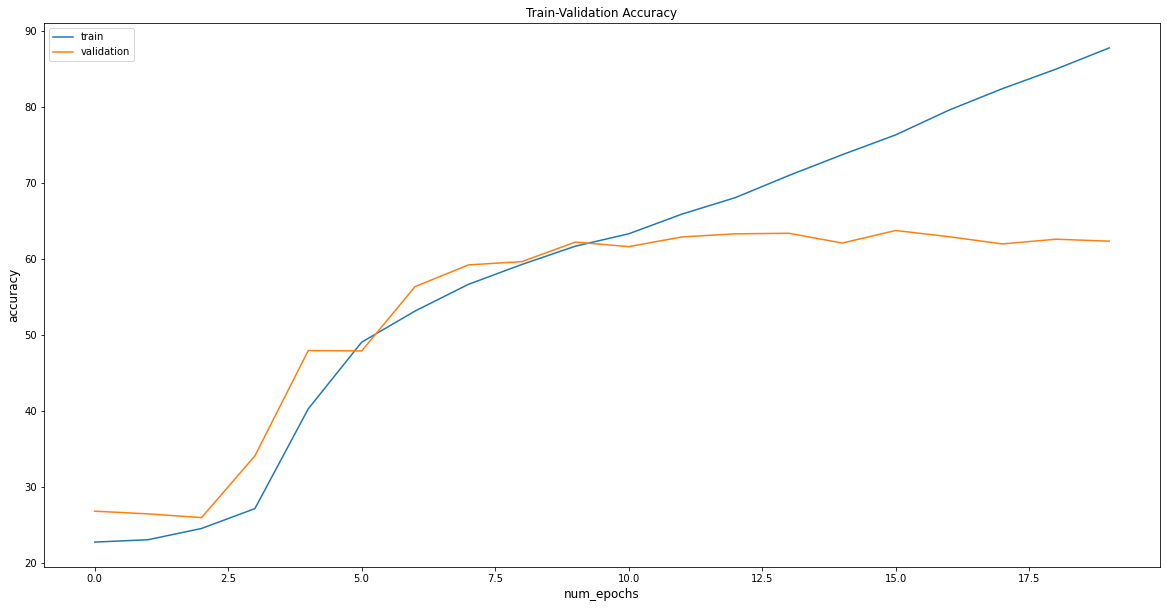

In [9]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')